2018 Edition<br>
### <div class='label label-info'>Luca LOMBARDO and Claudio SCALZO</div>

# Challenge: What is the future selling price of a home?

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

# The dataset

### File descriptions

* train.csv - <i>the training dataset</i>
* test.csv - <i>the test dataset</i>
* data_description.txt - <i>full description of each column</i>

# Goal of the challenge

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

### Metric
Notebooks are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

### Submission File Format
The file should contain a header and have the following format:

```
Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
```

You will find an example submission file within the data directory in the repository.

# Grading the notebook

This challenge is going to be graded as a regular notebook for the AML labs. As a consequence, students should submit:

* the html version of the notebook, using the Data Science Labs submission website, as usual [**Assignment: Challenge Notebook**]
* the submission file (in csv format), that we will use to rank students according to the metric defined above, again through the Data Science Labs submission website [**Assignment: Challenge Predictions**]

In summary, you will have to submit 2 files!

# 0. Preliminary operations

<div class='alert alert-info'>
In this section we are going to import all the libraries, declare the base paths and load in memory our training and test data. At the moment we don't import libraries regarding machine learning models: we will do in the appropriate section.
</div>

In [1]:
%%capture

# LIBRARIES IMPORT
# <-- data manipulation and exploration --> 
import numpy as np
import pandas as pd
from scipy.stats import skew, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from collections import Counter

# <-- plot -->
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from IPython.display import display, HTML, display_html
from pprint import pprint

# <-- utilities -->
import random
from copy import deepcopy
from time import time
from datetime import datetime
import warnings


# FUNCTIONS
def compareSideBySide(*tables, index, header, title):
    htmlStr = "<br><p style='text-align: left'>" + title + "</p>"
    for table in tables:
        htmlStr += pd.DataFrame(data=table, columns=header, index=index).to_html(index=True)
    display_html(htmlStr.replace('<table','<table style="float:left; margin-right: 20px"'), raw=True)
    print()


# INITS
sns.set(style="whitegrid", palette="Greens_r", font_scale=1.3)
warnings.simplefilter(action='ignore')

In [2]:
# PATH AND FILES DEFINITION
basePath = "./challenge_data/"
trainFile = basePath + "train.csv"
testFile = basePath + "test.csv"

In [3]:
# LOAD THE TRAINSET AND THE DATASET
train = pd.read_csv(trainFile)
test = pd.read_csv(testFile)

# PRINT TO DESCRIBE
print("Houses:", train.shape[0])
print("Attributes:", train.shape[1] - 2, "(without considering the ID and the SalePrice)")
display(train.head(10))

Houses: 1200
Attributes: 79 (without considering the ID and the SalePrice)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


<div class='alert alert-success'>
The dataset is very small, only <b>1200 rows</b> (houses) with <b>81 columns</b> (79 attributes + <tt>ID</tt> + <tt>SalePrice</tt>). We have everything we need to manipulate and make plot on data in order to explore and clean them. Let's move on.
</div>

# 1. Descriptive statistics

<div class='alert alert-info'>
The first step is to investigate data. It is a fundamental section, where we will learn about our data. Initially we show and plot really simple statistics: they are not really interesting but they are useful to introduce us, to understand what we are dealing with. Of course, then we will go deeper trying to analyze feature types, correlations, outliers, missing values, skewness: all the most important aspects that we must consider in order to perform a really good data cleaning.
</div>

In [4]:
# ANALYZE ONLY THE NUMERICAL VALUES
numericalAttributes = train.select_dtypes(exclude="object").drop(columns="Id").columns.values

# COMPUTE SOME BASIC STATISTICS
print("Original numerical ('int64' and 'float64') attributes:", train[numericalAttributes].shape[1] - 1, "(without considering the SalePrice)")
display(train[numericalAttributes].describe())

Original numerical ('int64' and 'float64') attributes: 36 (without considering the SalePrice)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,45.260000,...,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,158.931453,...,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,0.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,...,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


<div class='alert alert-success'>
The numerical attributes (excluded the <tt>ID</tt> and the <tt>SalePrice</tt>) are 36. Of course the "numerical" word doesn't have the same meaning for all of them: we can find years, which of course represent different values than prices, areas, lengths or even categorical attributes encoded with numerical values. However, being each of them numerical, we computed this description thank to which we can see some basic statistics on our data. For example, we can immediately see that until the 75th percentile no houses have a pool: this can be useful for our model. We'll see later which attributes will impact more the model outcome.<br>
<br>
Before going ahead, let's analyze the <tt><i>"object"</i></tt> attributes:
</div>

In [5]:
# GET THE CATEGORICAL ATTRIBUTES
categoricalAttributes = train.select_dtypes(include="object").columns.values

# COMPUTE SOME BASIC STATISTICS
print("Original categorical ('object') attributes:", train[categoricalAttributes].shape[1])
display(train[categoricalAttributes].describe())

Original categorical ('object') attributes: 43


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1200,1200,75,1200,1200,1200,1200,1200,1200,1200,...,1133,1133,1133,1133,1200,4,227,47,1200,1200
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,946,1194,41,754,1079,1199,862,1135,179,1035,...,718,500,1081,1093,1107,2,130,44,1036,979


<div class='alert alert-success'>
For the <tt><i>"object"</i></tt> attributes of course we can't compute means, maxs or percentiles: they are not numeric values! However other kind of statistics can be computed: we can see for example that each attribute doesn't have the same count. Maybe there is something wrong or missing, we are going to investigate about it in the next section.<br>
<br>
Now, let's concentrate on out target variable: <tt>SalePrice</tt>.
</div>

## <span style='color:#333333'>1.1 Target variable</span>

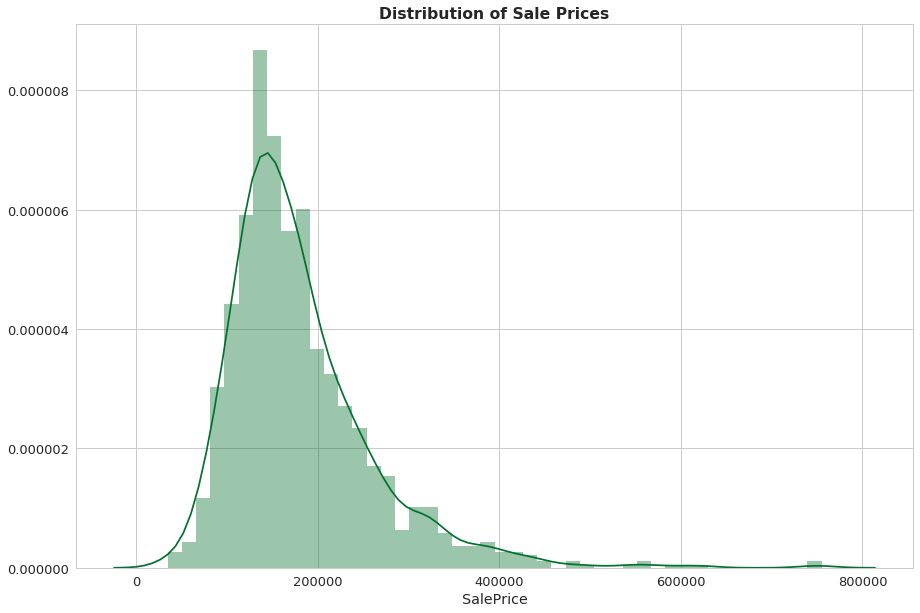

In [6]:
# PLOT THE DISTRIBUTION OF THE TARGET VARIABLE
plt.figure(figsize=(15,10))
sns.distplot(train["SalePrice"])
plt.title("Distribution of Sale Prices", weight="semibold");

<div class='alert alert-success'>
We can see that is very frequent that our <tt>SalePrice</tt> has a value between <i>100'000&dollar;</i> and <i>200'000&dollar;</i>. The distribution is not symmetric but it's left-skewed, with a short tail on the left and a long tail on the right: this could lead (or maybe not) to some difficulties for our model. Let's investigate more with the probability plot.
</div>

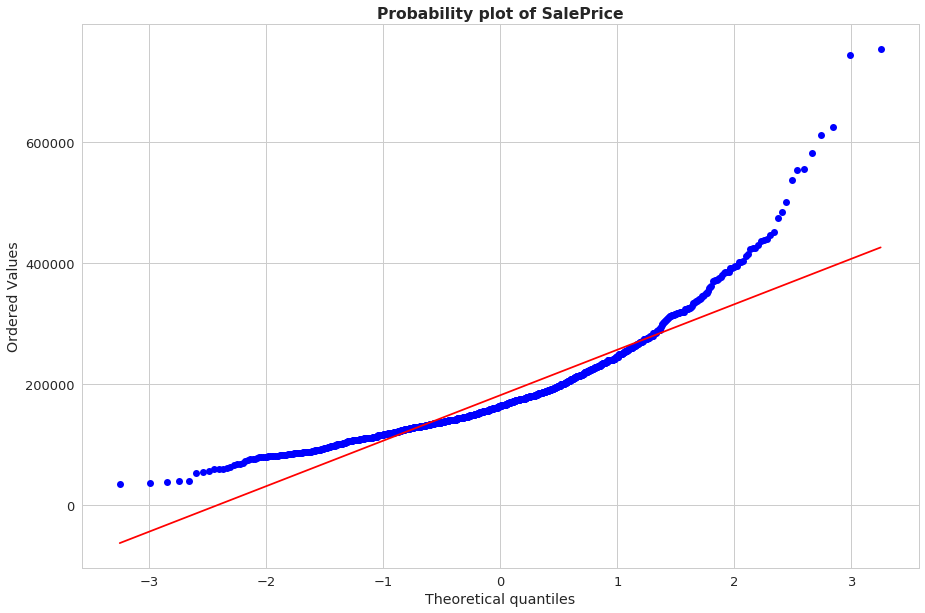

In [7]:
# PROBABILITY PLOT (SKEWNESS)
plt.figure(figsize=(15,10))
probplot(train['SalePrice'], plot=plt)
plt.title("Probability plot of SalePrice", weight="semibold")
plt.show()

<div class='alert alert-success'>
With these plots we can appreciate the skewness of the data and notice that we have a left-skewed target variable. It is normal in reality (only few people have an expensive house) but it's not good for our models. In order to catch the problem think about linear regression, where we find to minimize the square of the losses: using original target values we will have huge errors on the most expensive houses, and for this reason the algorithm leads to fit better these points in order to minimize the overall error; in few words the expensive houses will drive our model and the cheapest ones will be on the back burner. Is it okay? Considering that the majority of houses have a low-medium price... is not good at all! <br>
<br>
Now let's build the correlation matrix (of course on the numerical attributes) and check which attributes have the strongest correlation between them:
</div>

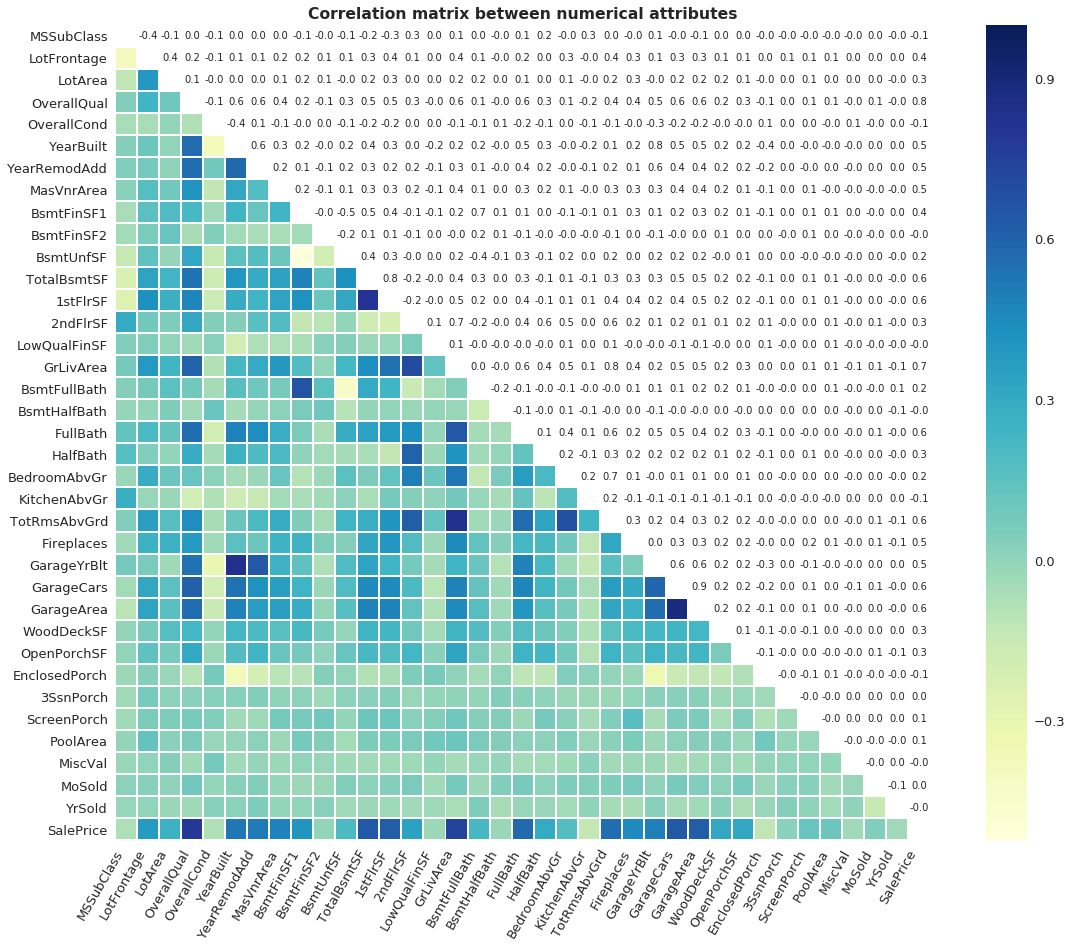

In [8]:
## CORRELATION MATRIX FOR NUMERICAL ATTRIBUTES

# BUILD THE CORRELATION MATRIX BETWEEN NUMERIC (int64 and float64) ATTRIBUTES
correlationMatrix = train[numericalAttributes].corr()

# PLOT THE CORRELATION MATRIX
plt.figure(figsize=(20,15))
plt.title("Correlation matrix between numerical attributes", weight="semibold");

# Build the Color Correlation Matrix
mask = np.zeros_like(correlationMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap="YlGnBu", fmt = '.1f', square = True, mask=mask, linewidths=1.0);

# Build the Values Correlation Matrix
mask[np.triu_indices_from(mask)] = False
mask[np.tril_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap=ListedColormap(['white']), square = True, fmt = '.1f', linewidths=1.0, mask=mask, annot=True, annot_kws={"size":10}, cbar=False);
g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right");

<div class='alert alert-success'>
We can see that there are some values which are highly correlated. For example, <tt>'GrLivArea'</tt> <i>(Ground living area in square feet)</i> and <tt>'TotRmsAbvGrd'</tt> <i>(Total rooms above ground)</i>: this is clearly normal, because is highly probable that an house with a bigger ground living area has more rooms!<br>
There are also some negatively correlated attributes, like <tt>'BsmtFullbath'</tt> <i>(Full bathrooms in the basement)</i> and <tt>'BsmtUnfSF'</tt> <i>(Unfinished area in the basement)</i>, and this can be normal too: if there are a lot of bathrooms is highly unprobable that there is a big unfinished area in the same place.<br>
<br>
Of course these are just examples, what we can begin to care about are the attributes which are highly correlated with our target attribute: <tt>'SalePrice'</tt>. Let's check the correlation between the **8 most correlated** attributes (the ones with correlation value >= 0.6):
</div>

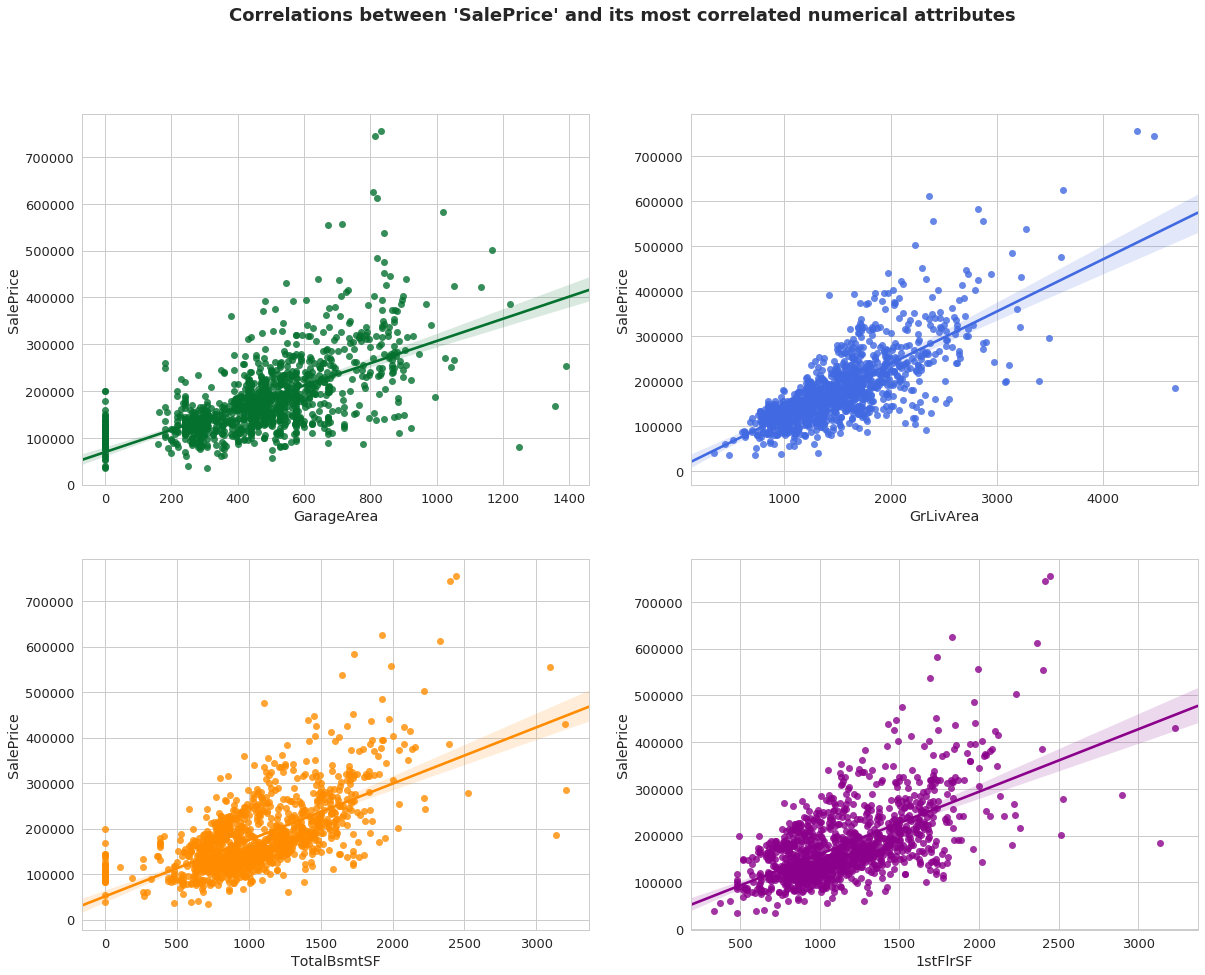

In [9]:
# PLOT THE CORRELATIONS BETWEEN 'SalePrice' AND ITS MOST CORRELATED ATTRIBUTES
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.regplot(x="GarageArea", y="SalePrice", data=train, ax=ax1,);
sns.regplot(x="GrLivArea", y="SalePrice", data=train, ax=ax2, color="royalblue");
sns.regplot(x="TotalBsmtSF", y="SalePrice", data=train, ax=ax3, color="darkorange");
sns.regplot(x="1stFlrSF", y="SalePrice", data=train, ax=ax4, color="darkmagenta");
plt.suptitle("Correlations between 'SalePrice' and its most correlated numerical attributes", weight="semibold", fontsize=18);

<div class='alert alert-success'>
The attributes are of course correlated: we find that the <i>garage area</i>, the <i>ground living area</i>, the <i>basement area</i> and the <i>first floor area</i> are 4 of the most important attributes to decide the Sale Price of an house. What leads to some difficulties for the work of the linear regression are <b>outliers</b>: we're going to deal with them in the data pre-processing phase later.<br>
<br>
The other two highly correlated attributes are numerical outside, but "categorical" inside: indeed, we found out that they were just ordinal attributes encoded with numeric values (for example a scale from 0 to 10). For this reason, we're going to plot a boxplot instead of the regression plot. In the data pre-processing phase, we're going to transform all the attributes in numerical values, and we'll recompute the correlation matrix.<br>
<br>
At the moment, let's draw the boxplots:
</div>

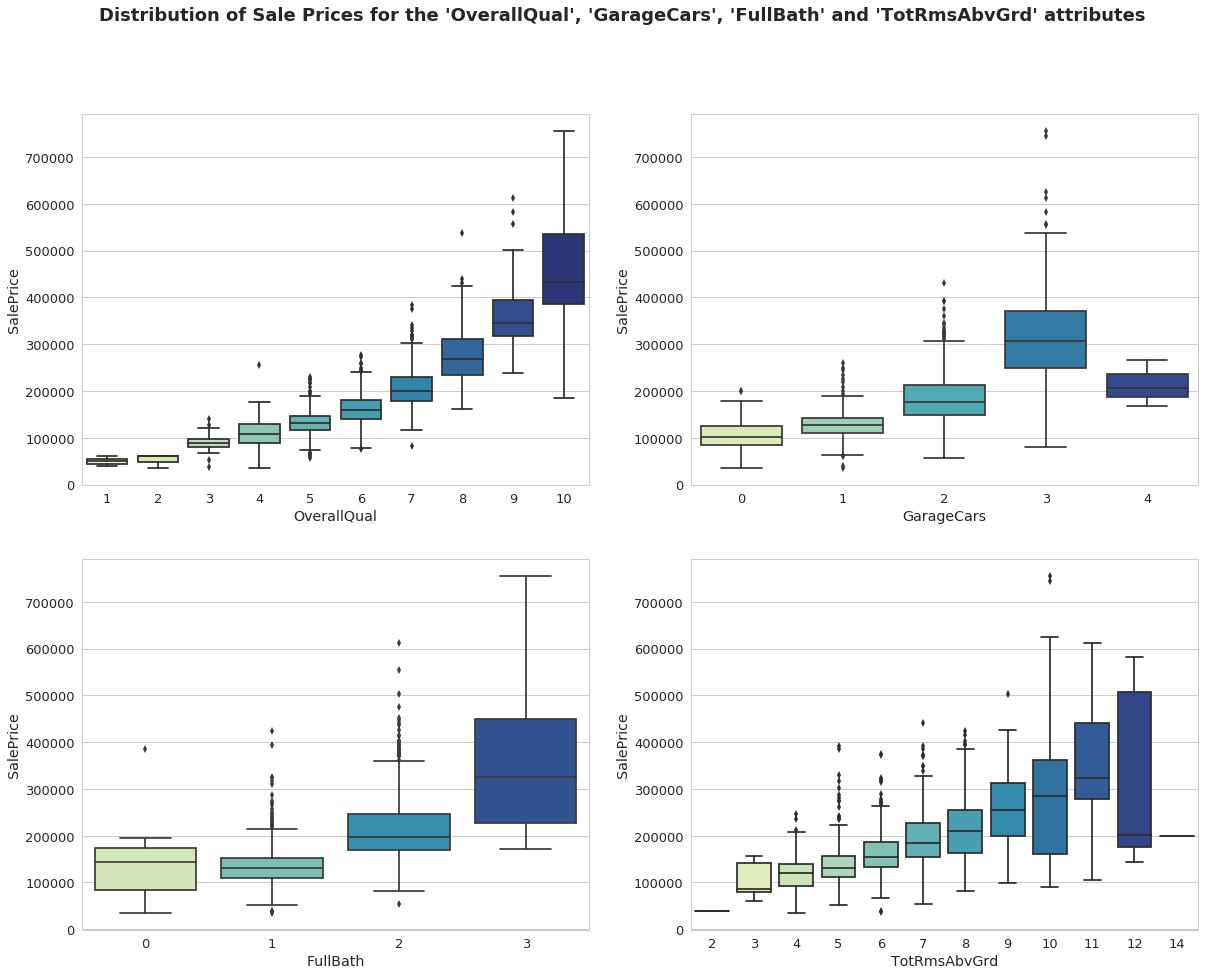

In [10]:
# PLOT THE BOXPLOTS FOR 'OverallQual','GarageCars', 'FullBath' AND 'TotRmsAbvGrd' ATTRIBUTES
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.boxplot(x="OverallQual", y="SalePrice", data=train, ax=ax1, palette="YlGnBu");
sns.boxplot(x="GarageCars", y="SalePrice", data=train, ax=ax2, palette="YlGnBu");
sns.boxplot(x="FullBath", y="SalePrice", data=train, ax=ax3, palette="YlGnBu");
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=train, ax=ax4, palette="YlGnBu");
plt.suptitle("Distribution of Sale Prices for the 'OverallQual', 'GarageCars', 'FullBath' and 'TotRmsAbvGrd' attributes", weight="semibold", fontsize=18);

<div class='alert alert-success'>
Also in this case, we find outliers, especially in the plot referred to the <tt>'TotRmsAbvGrd'</tt> attribute. We can notice that just one house has 2 rooms, and just one house has 14 rooms. However, we considered an outlier only the house with 14 rooms: the one with 2 rooms, seems in line with an hypotetical regression line passing through our data! It is a really particular case a house with a lot of rooms and a price similar to those with 7-8 rooms. We're going to delete the outlier house in the data pre-processing phase. Another interesting (and similar) fact we can notice, is that the <b>median</b> in case of 12 rooms is really low and out of an "imaginary regression line".
</div>

## <span style='color:#333333'>1.2 Missing values</span>

<div class='alert alert-info'>
Missing values is one of the most important aspects that we must care when doing data analysis and prediction. Detecting them is really easy (and this part is the proof) but the most difficult part comes when we have to fill it. How do we decide the right value? It is a crucial decision because a wrong or misleading value leads to bad predictions.
</div>

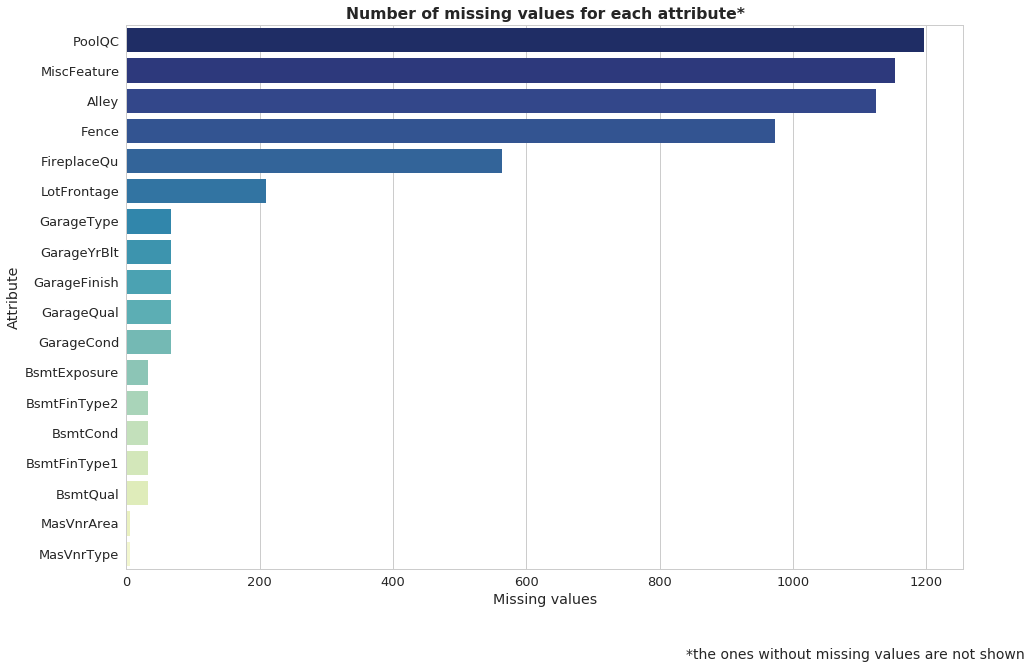

In [11]:
## MISSING VALUES FOR EACH ATTRIBUTE

# EXPLORATIVE ANALYSIS ON MISSING VALUES
trainMissing = train.isnull().sum()
trainMissing = trainMissing[trainMissing != 0]
trainMissing = pd.DataFrame({"attribute":trainMissing.index, "count":trainMissing.values}).sort_values(by="count", ascending=False)

# PLOT THE BARPLOT
plt.figure(figsize=(15,10))
g = sns.barplot(y="attribute", x="count", data=trainMissing, palette="YlGnBu_r");
plt.ylabel("Attribute");
plt.xlabel("Missing values");
plt.title("Number of missing values for each attribute*", weight="semibold");
plt.figtext(0.8,0,"*the ones without missing values are not shown", fontsize=14, ha='center');

<div class='alert alert-success'>
We have a lot of missing (<tt>NaN</tt>) values! As we'll explain after, for each column a missing value can mean different things. We're going to deal with them, correcting the lack of information, in the section. For the moment just remember this important issue.
</div>

## 1.3 Skewness

<div class='alert alert-info'>
Skewness is about distribution of values for each attribute. We should care about and we have to know how the models we use work. That's because every model make assumptions: normal distribution, independence between variables and so on and so forth. The more we can find the assumptions in our data, the higher will be the model performances.
</div>

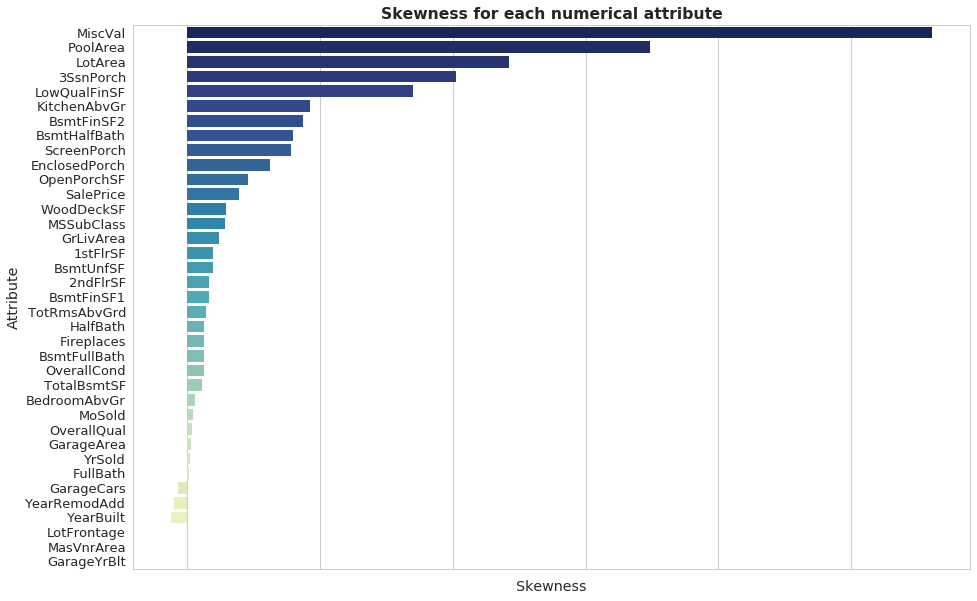

In [12]:
## SKEWNESS FOR EACH NUMERICAL ATTRIBUTE

# COMPUTE SKEW FOR EACH OF THE NUMERICAL ATTRIBUTES
trainSkews = train[numericalAttributes].apply(lambda x: skew(x)).sort_values(ascending=False)
trainSkews = pd.DataFrame({'Attribute': trainSkews.index, 'Skew': trainSkews.values})

# PLOT THE BARPLOT
plt.figure(figsize=(15,10))
g = sns.barplot(y="Attribute", x="Skew", data=trainSkews, palette="YlGnBu_r");
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right");
plt.ylabel("Attribute");
plt.xlabel("Skewness");
plt.title("Skewness for each numerical attribute", weight="semibold");

<div class='alert alert-success'>
We can clearly see from the plot that some attributes have a really high skewness index. This is a big issue for us, in addition to the skewness of our target variable: we are going to use models that are really sensitive (especially the simplest ones) to this fact. In the next part we will talk about our decision on how to handle this problem.
</div>

# 2. Data cleaning and pre-processing

<div class='alert alert-info'>
Now we're going to face the data pre-processing phase. In the first part we discovered and highlighted some important issues. Now it is time to fix. First of all, we need to do our operations in both training and test set (except for the outlier removal phase, of course). We can start.
</div>

In [13]:
# CREATE THE 'allData' DATAFRAME (TRAIN + TEST)
allData = pd.concat((train, test)).reset_index(drop=True)

## <span style='color:#333333'>2.1 Dealing with missing values</span>

<div class='alert alert-info'>
The entire dataset contains, as often happens, a lot of missing values. It's important to notice that in each case, a missing value can have a <b>different meaning</b>: for example, can represent an unknown information, or can represent the lack of the property referred to that attribute! So, it's fundamental to look at the dataset description to check which is the exact meaning of the <tt>NaN</tt> value on a given column.<br>
<br>
We can start from categorical attributes. For them, every <tt>NaN</tt> represents just the lack of that given attribute (for example no pool, no basement): it's enough to fill all the missing values with the <tt>"None"</tt> value. Let's do that:
</div>

In [14]:
# FILLING FOR "object" ATTRIBUTES
categoricalAttributes = allData.select_dtypes(include = "object").columns.values

# FILL THEM WITH THE None VALUE  
allData = allData.apply(lambda col: col.fillna("None") if col.name in categoricalAttributes else col)

<div class='alert alert-success'>
For numerical attributes the situations is a bit more complex, because we should reason about them case by case. <br>
<br>
We figured out that we have two simple cases: <tt>GarageYrBlt</tt> and <tt>MasVnrArea</tt> are two attributes where we can repeat what we've said about categorical values. In this case of couse, we fill in with a 0 because they want a numerical values. At the moment we don't care about the proper type for the attributes, we will do further in the notebook.
</div>

In [15]:
# VALUES FOR WHICH NaN MEANS "NOT PRESENT"
zeroList = ["GarageYrBlt", "MasVnrArea"]
    
# FILL THEM WITH THE None VALUE  
allData = allData.apply(lambda col: col.fillna(0) if col.name in zeroList else col)

<div class='alert alert-success'>
<b>The lot frontage issue</b><br>
<br>
The most complicated attribute to fill is the <tt>LotFrontage</tt>. There are some missing values that needs to be filled, but of course the value which has to replace the <tt>NaN</tt> has to be meaningful to facilitate the model's learning and prediction.<br>
A first way (that we choose to not follow) is to fill these values with the median of the others values of <tt>LotFrontage</tt>. Can be a reasonable approximation, but maybe can be improved!<br>
<br>
Indeed, reasoning about the meaning of the <tt>LotFrontage</tt> attribute (and checking other attributes), we thought that a reasonable approximation could be to correlate the missing <tt>LotFrontage</tt> to other values like the <tt>Neighborhood</tt> and the <tt>LotArea</tt>.<br>
In more concrete words, for each row with a missing <tt>LotFrontage</tt> we build <b>a little "chart"</b> of houses in the same neighboorhood with the most similar street in terms of <tt>LotArea</tt>: we take choose that value to be our <tt>LotFrontage</tt>. Indeed, we thought that this is a reasonable approximation: in the same neighborhood, an house with a given value of lot area should have a similar value of frontage! Of course is always an approximation, but we think that is <b>better</b> than just taking the median of all the houses in all neighborhoods of the dataset.
</div>

In [16]:
# FACE UP THE LOT FRONTAGE ISSUE

# Create two copies: a read one and a write one
allDataOnlyRead = deepcopy(allData)

# For each row...
for index, row in allData.iterrows():
    
    # ...if the 'LotFrontage' is NaN
    if np.isnan(row["LotFrontage"]):
        
        # Compute the neighborhood
        neighborhood = allDataOnlyRead[allDataOnlyRead["Neighborhood"] == row["Neighborhood"]]\
            [["LotFrontage", "LotArea"]].dropna().reset_index()
        
        # Take the index of the most similar street (in the neighborhood)
        closerIndex = (neighborhood["LotArea"] - row["LotArea"]).abs().argsort()[:1]
        
        # Assign the value to the original trainset
        allData.at[index, "LotFrontage"] = neighborhood.loc[closerIndex]["LotFrontage"]

In [17]:
# BUILD A SAMPLE TO SHOW SOME NaNs
sampleWithNaN = allDataOnlyRead[allDataOnlyRead["Neighborhood"] == 'Mitchel'][["LotFrontage","LotArea"]].sort_values(by="LotArea", ascending=False).head(15)

# BUILD A SAMPLE WITH REMOVED NaNs
sampleWithoutNaN = allData[allData["Neighborhood"] == 'Mitchel'][["LotFrontage","LotArea"]].sort_values(by="LotArea", ascending=False).head(15)

# COMPARE
compareSideBySide(sampleWithNaN.as_matrix(),
                  sampleWithoutNaN.as_matrix(),
                  index=sampleWithNaN.index,
                  header=["LotFrontage","LotArea"],
                  title="<tt>LotFrontage</tt> in the <i>Mitchel</i> neighborhood: before and after the NaN removal")

,LotFrontage,LotArea
1190,NaN,32463.0
1446,NaN,26142.0
876,94.0,25286.0
943,100.0,25000.0
422,100.0,21750.0
1048,100.0,21750.0
1434,80.0,17400.0
1453,90.0,17217.0
5,85.0,14115.0
817,NaN,13265.0


## <span style='color:#333333'>2.2 Removing outliers</span>

<div class='alert alert-info'>
We're now going to remove some outliers. We'll remove the points which area clearly outside and very far from the ideal regression for the "Attribute/SalePrice" data or looking at the boxplot distributions.<br>
We'll do that also for a restricted set of attributes, just the ones which are higly correlated to our <tt>SalePrice</tt> target.
</div>

In [18]:
# REMOVING OUTLIERS FOR HIGHLY CORRELATED ATTRIBUTES
# (ONLY FOR TRAIN-SET!)

# TEMPORARY SPLIT
train = allData[:1200]
test = allData[1200:]

# OUTLIER REMOVAL
# SalePrice
train = train.drop(train[train['SalePrice'] > 440000].index)
# OpenPorchSF
#train = train.drop(train[(train['OpenPorchSF'] > 20) & (train['SalePrice'] < 45000)].index)
# GarageCars
train = train.drop(train[(train['GarageCars'] == 2) & (train['SalePrice'] > 305000)].index)
# OverallQual
train = train.drop(train[(train['OverallQual'] == 8) & (train['SalePrice'] > 410000)].index)
# TotRmsAbvGrd
train = train.drop(train[(train['TotRmsAbvGrd'] == 12) | (train['TotRmsAbvGrd'] == 14)].index)

# RE-JOIN
allData = pd.concat((train, test)).reset_index(drop=True)

print("Now the number of rows (which was " + str(allDataOnlyRead.shape[0]) + ") is " + str(allData.shape[0]))

Now the number of rows (which was 1460) is 1419


<div class='alert alert-success'>
<b>Why these removals?</b><br>
<ul>
<li>First of all, we noticed that a lot of outliers (far from an ideal regression line) generally had a big <tt>SalePrice</tt>. We tried to remove the excessively high priced houses that can interfere with the regression: the threshold has been put, looking at the plots, to 440'000.</li>
<li>Then, as we've seen from the previous box plots, some attributes had a big quantity of outliers with respect to the target variable <tt>SalePrice</tt>. One of these is <tt>GarageCars</tt>: we decided to remove the outliers referred to the houses with garages large as two cars and with a big <tt>SalePrice</tt> (greater than 305'000). The threshold has of course been chosen looking at the box plot values.</li>
<li>A similar situation applies to the <tt>OverallQual</tt> box plot: we removed the houses with <tt>SalePrice</tt> greater than 410000 and <tt>OverallQual</tt> equal to 8, because of the presence of very "far" points from the regression line.</li>
<li>The last step we did in this "manual" outlier removal regards the <tt>TotRmsAbvGrd</tt> attribute. We noticed, indeed, that the houses with 14 rooms are totally not coherent with the regression. Moreover, the houses with 12 rooms have a distribution which is also problematic: even if the values of this attribute are widely spread in the TotRmsAbvGrd/SalePrice space (with not so many outliers), the median of the distribution is very low comparing it to the trend of the other houses: we decided to delete them too.</li>
</ul>
</div>

<div class='alert alert-warning'>
<b>Is it enough?</b><br>
<br>
No. Absolutely. We made an important step further but we can't say that everything about outliel-removal is over. Analyzing only the most correlated features we cared about a small portion of all information. The big issue here is that we are dealing with a large number of attributes. An idea could be plot each attribute and remove by hand in each of them but it is a waste of time because it is not the right way to proceed (demanding time and not so effective). When we are talking about really high correlated features it makes sense: misleading values here probably make worse the model (and in addition we have only a small number of them, super-easy to handle). But when we talking about the majority of attributes it is better make considerations about outlier in a more general context, analyzing the data from a general point of view. This point of view is the result of the PCA, that we are going to do in a while.
</div>

<div class='alert alert-success'>
Now we're going to re-plot the distributions of our 8 most "<tt>SalePrice</tt>-correlated" attributes and see if they improved our regressions.
</div>

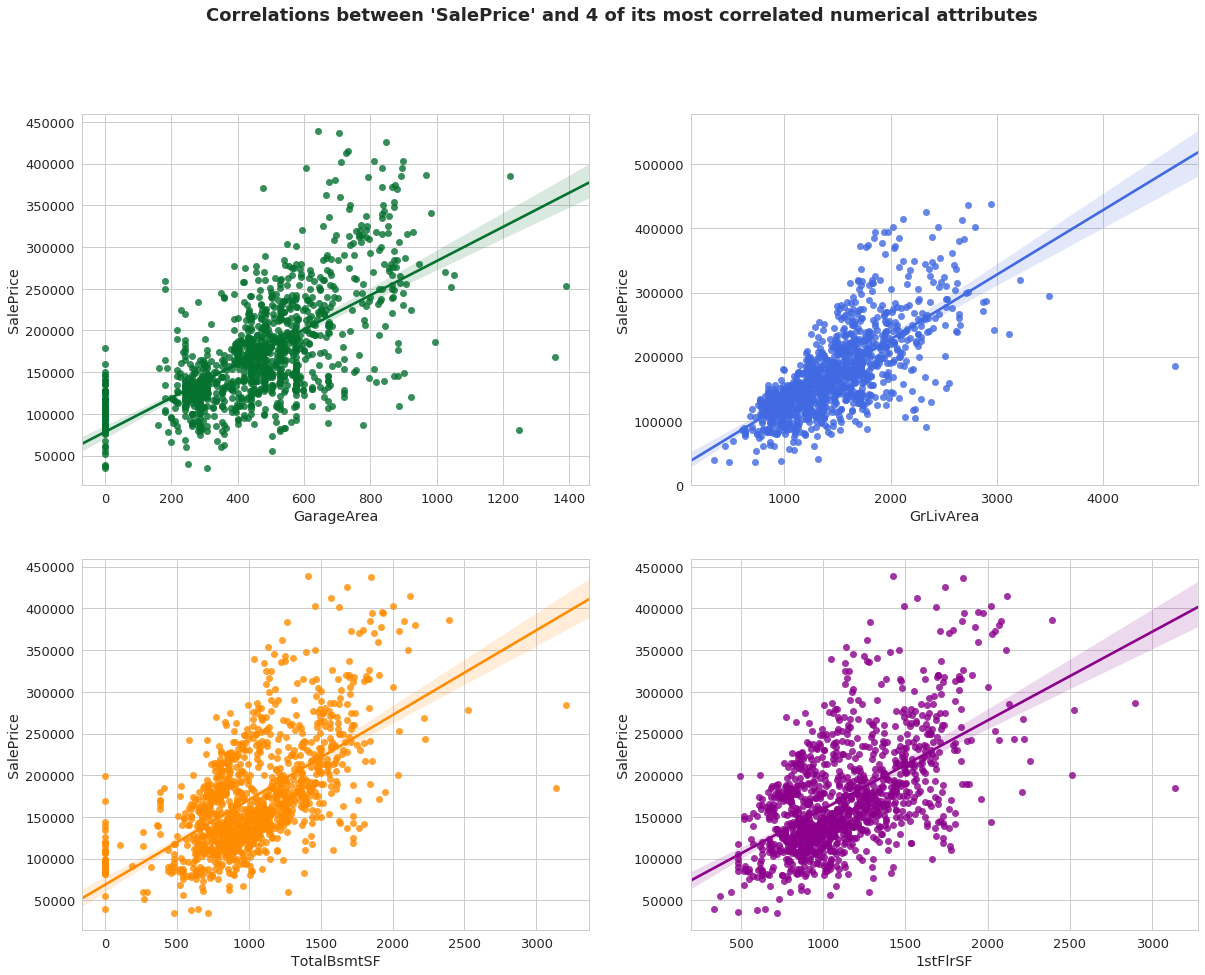

In [19]:
## RE-PLOT THE CORRELATIONS BETWEEN 'SalePrice' AND ITS MOST CORRELATED NUMERICAL ATTRIBUTES

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.regplot(x="GarageArea", y="SalePrice", data=allData, ax=ax1);
sns.regplot(x="GrLivArea", y="SalePrice", data=allData, ax=ax2, color="royalblue");
sns.regplot(x="TotalBsmtSF", y="SalePrice", data=allData, ax=ax3, color="darkorange");
sns.regplot(x="1stFlrSF", y="SalePrice", data=allData, ax=ax4, color="darkmagenta");
plt.suptitle("Correlations between 'SalePrice' and 4 of its most correlated numerical attributes", weight="semibold", fontsize=18);

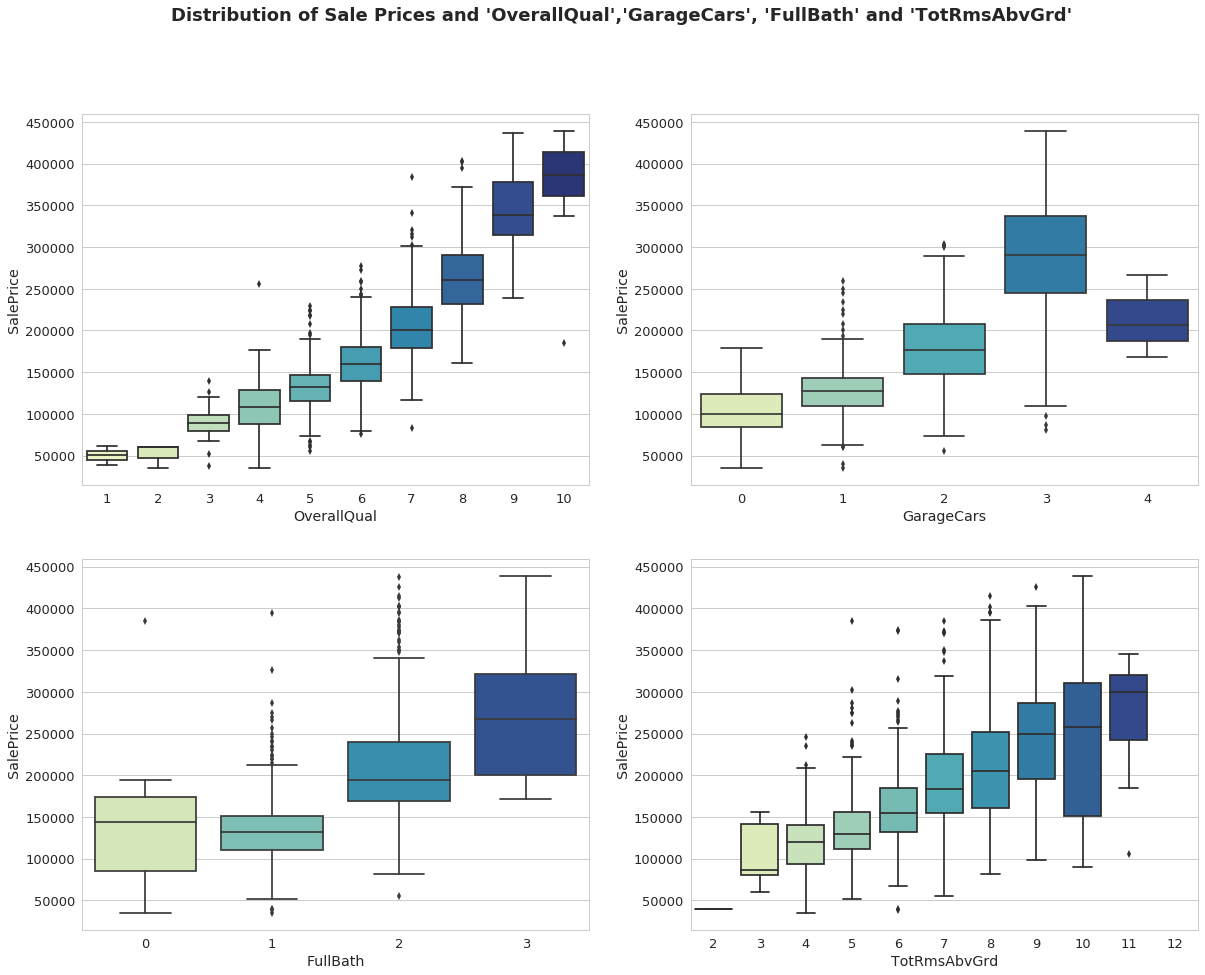

In [20]:
## RE-PLOT THE BOXPLOTS FOR 'OverallQual','GarageCars', 'FullBath' AND 'TotRmsAbvGrd' ATTRIBUTES

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.boxplot(x="OverallQual", y="SalePrice", data=allData, ax=ax1, palette="YlGnBu");
sns.boxplot(x="GarageCars", y="SalePrice", data=allData, ax=ax2, palette="YlGnBu");
sns.boxplot(x="FullBath", y="SalePrice", data=allData, ax=ax3, palette="YlGnBu");
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=allData, ax=ax4, palette="YlGnBu");
plt.suptitle("Distribution of Sale Prices and 'OverallQual','GarageCars', 'FullBath' and 'TotRmsAbvGrd'", weight="semibold", fontsize=18);

<div class='alert alert-success'>
As we can clearly see, the situation is now clearly better. The outliers (or in better words, the data points we considered to be outliers) have been removed. We can go ahead.
</div>

## <span style='color:#333333'>2.3 Label Encoding and DataType Correction</span>

<div class='alert alert-info'>
Some categorical attributes are originally "objects" in our dataset. In order to make the model work, we have to transform them into numerical (ordinal) attributes, like the <tt>'OverallQual'</tt> and <tt>'OverallCond'</tt> originally are (scale from 1 to 10).<br>
<br>
We're going to use <b>Label Encoding</b> and the <b>OneHot Encoding</b>, and we explain why:<br>
<br>
<list>
    <li>the Label Encoding is useful when we want to transform the categorical attribute in a numeric one, <b>keeping the ordinality information</b>. This means that if an attribute range is [<i>"none"</i>, <i>"bad"</i>, <i>"average"</i>, <i>"good"</i>, <i>"excellent"</i>], makes sense to transform it into [0, 1, 2, 3, 4].</li>
    <li>the One Hot Encoding is useful when we want to transform categorical attributes into numerical ones, but <b>without</b> letting the numerical value to be ordinal. This means that if an attribute has a domain range like ["red", "green", "blue"] can be a problem to transform it into a [0, 1, 2] range, because the model will learn an ordinality which is not present in reality! In these cases we use a One Hot Encoding, that duplicates the columns for a given attribute, and gives the value 0 or 1.</li> 
</list><br>
In our case, analyzing all the attributes in the data description, we noticed that for some attributes was more appropriate to use the LabelEncoder, for others the <tt>OneHotEncoder</tt>.<br> There are some exceptions: some attributes with cardinality 2; in that case, even if we don't want an "ordinality" information, using a OneHotEncoder is totally useless because the value can be just one thing or another (0 or 1 in a numerical fashion). These attributes are, for example, <tt>"CentralAir"</tt> and <tt>"Street"</tt>.<br>
<br>
Instead of the scikit-learn <tt>OneHotEncoder</tt> function, we used the Pandas <tt>get_dummies</tt>: it can be done on the entire dataframe (of course only in the attributes we want to apply it) with a single call, without looping through the columns. It has a useful features (<i>drop_first</i>) that helps to avoid the "dummy variable trap" (<a href="http://www.algosome.com/articles/dummy-variable-trap-regression.html">source</a>):<br>
in simple words, is always useful to drop the first variable during a categorical variables encoding in a one-hot fashion, to avoid a non-desired collinearity.
</div>

In [21]:
## ENCODING OF CATEGORICAL (NOMINAL) ATTRIBUTES

# COLLECT IN A LIST THE CATEGORICAL ATTRIBUTES WITHOUT THE "ORDINAL" SCALE
notOrderedColumns = ['MSZoning', 'Alley', 'LandContour', 'LotConfig','Neighborhood', 'Condition1', 'Condition2','BldgType',
                     'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','Foundation',
                     'Heating', 'Electrical', 'GarageType','MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']

# USE THE ONE-HOT ENCODER FOR THESE ATTRIBUTES
allData = pd.get_dummies(allData, columns=notOrderedColumns, drop_first=True)

<div class='alert alert-success'>
Now we're going to encode the categorical attributes that have an "ordinality" information inside. Some of them were just of <tt>"object"</tt> type, but others were not! They were just "categorical" (ordinal) attributes encoded as <tt>int64</tt>. In the encode function we take care of this.
</div>

In [22]:
## ENCODING OF CATEGORICAL (ORDINAL) ATTRIBUTES

# ENCODING FUNCTION
def encode(col):
    if col.dtype == np.object:
        return LabelEncoder().fit_transform(col).astype(np.uint32)
    elif (col.name == 'OverallQual' or col.name == 'MSSubClass' or col.name == 'OverallCond' or col.name == 'Id' or \
         col.name == 'MoSold' or col.name == 'YrSold' or col.name == 'YearRemodAdd' or col.name == 'YearBuilt' or \
         col.name == 'GarageYrBlt'):
        return col.astype(np.uint32)
    else:
        return col
    
# ENCODE THE CATEGORICAL VALUES IN NUMERICAL VALUES
allData = allData.apply(encode, axis=0, reduce=False)

# SHOW
display(allData.head(10))

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,856,854,0,3,4,3,706,0,2,6,...,1,0,0,0,0,0,0,0,0,0
1,1262,0,0,3,4,1,978,0,0,6,...,0,0,0,0,0,0,0,0,0,0
2,920,866,0,3,4,2,486,0,2,6,...,1,0,0,0,0,0,0,0,0,0
3,961,756,0,3,1,3,216,0,0,6,...,0,1,0,0,0,0,0,0,0,0
4,1145,1053,0,4,4,0,655,0,2,6,...,1,0,0,0,0,0,0,0,0,0
5,796,566,320,1,4,3,732,0,2,6,...,0,0,0,0,0,0,0,0,0,0
6,1107,983,0,3,4,2,859,32,0,1,...,1,0,0,0,0,0,0,0,0,0
7,1022,752,0,2,4,3,0,0,6,6,...,0,0,0,0,0,0,0,0,0,0
8,1077,0,0,2,4,3,851,0,2,6,...,0,0,0,0,0,0,0,0,0,1
9,1040,0,0,3,4,3,906,0,5,6,...,0,0,0,0,0,0,0,0,0,0


<div class='alert alert-success'>
As we saw in the previous parts of the notebook, we're dealing about numerical and categorical attributes. However, as previously said, some categorical attributes are already encoded as numerical values, other are just <tt>'objects'</tt>. With our encoding, we transformed all the <tt>'objects'</tt> to <tt>'np.uint8'</tt> values (which is also the format in which the 'get_dummies' function encodes the columns) to distinguish them from the numerical ones (<tt>'int64'</tt> or <tt>'float64'</tt>).<br>
<br>
Our assumptions have been done also recalling the Stevens Scale Levels:
<img src='http://my.ilstu.edu/~wjschne/138/Stevens.png' height="600" width="600">
<br>
We brought a coherent structure to our dataset. Now we can update our variables:
</div>

In [23]:
## UPDATE THE NUMERICAL AND CATEGORICAL ATTRIBUTES LIST

# NUMERICAL: exclude uint8 and uint32 (include int64 and float64)
numericalAttributes = allData.select_dtypes(exclude=["uint8", "uint32"]).drop(columns=["SalePrice"]).columns.values

# ORDINAL CATEGORICAL: include uint32
ordinalCategoricalAttributes = allData.select_dtypes(include="uint32").columns.values

# NOMINAL CATEGORICAL: include uint8
nominalCategoricalAttributes = allData.select_dtypes(include="uint8").columns.values

<div class='alert alert-success'>
Now we can print the correlation matrix for the categorical attributes! Before, indeed, was impossible because they were strings and not numerical values.
</div>

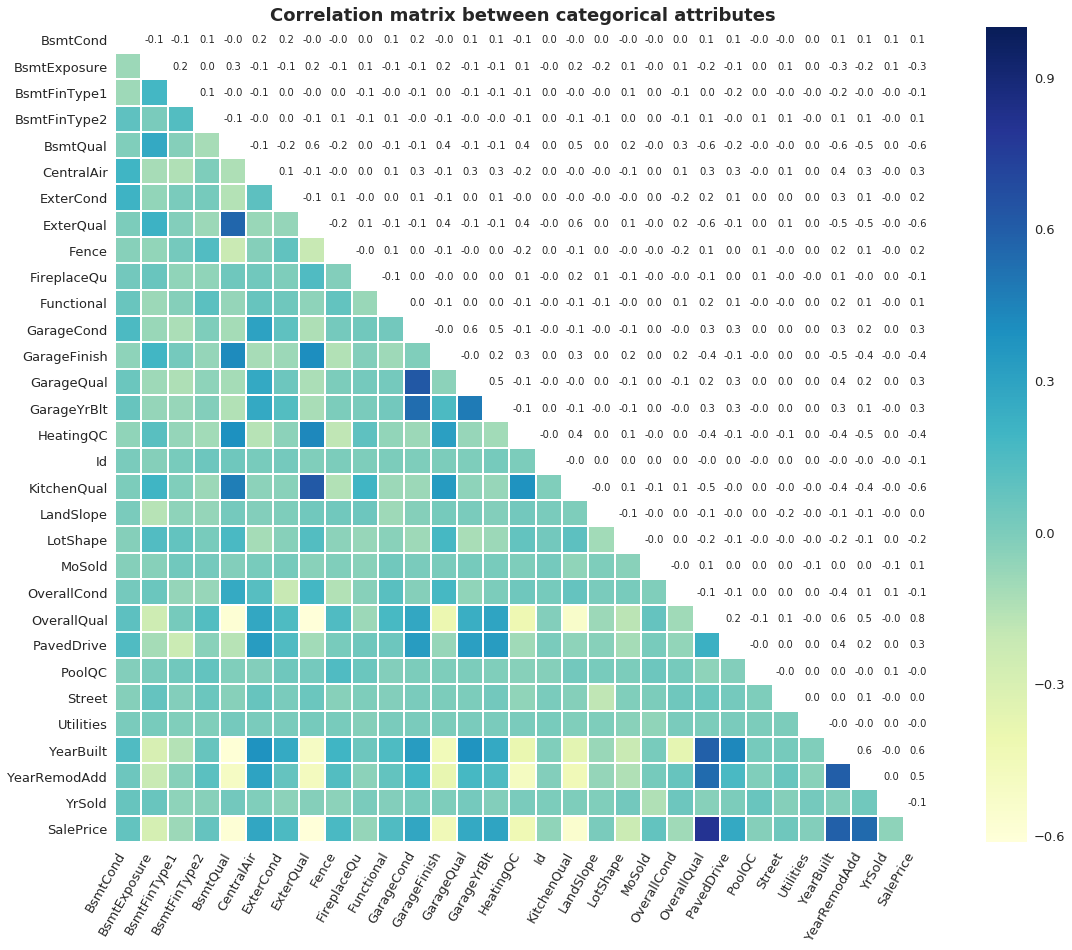

In [24]:
## PRINT AGAIN THE CORRELATION MATRIX (NOW FOR CATEGORICAL-ORDINAL ATTRIBUTES, THAT HAVE BECOME NUMERICAL)

# APPEND THE 'SalePrice' LABEL TO THE CATEGORICAL DATASET
allDataCategoricalWithSalePrice = allData[np.append(ordinalCategoricalAttributes, "SalePrice")]

# BUILD THE CORRELATION MATRIX BETWEEN CATEGORICAL-ORDINAL ATTRIBUTES AND 'SalePrice'
correlationMatrix = allDataCategoricalWithSalePrice.corr()

# PLOT THE CORRELATION MATRIX
plt.figure(figsize=(20,15))
mask = np.zeros_like(correlationMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap="YlGnBu", square = True, fmt = '.1f', mask=mask, linewidths=1.0);
mask[np.triu_indices_from(mask)] = False
mask[np.tril_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap=ListedColormap(['white']), square = True, fmt = '.1f', linewidths=1.0, mask=mask, annot=True, annot_kws={"size":10}, cbar=False);
g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right");
plt.title("Correlation matrix between categorical attributes", weight="semibold", fontsize=18);

<div class='alert alert-success'>
The correlation matrix highlights some high correlations between <tt>'Exterior1st'</tt> and <tt>'Exterior2nd'</tt> (the materials used to cover the house), or between the kitchen quality and the exterior quality. However, what do we care most is the last row, about <tt>SalePrice</tt>: we notice an high correlation with <tt>OverallQual</tt> (and this is someway obvious) but also a quite good correlation with <tt>YearBuild</tt>. During the modeling phase we will see if these attributes drive the models. But in general we can say that the numerical attributes had a bigger impact on our <tt>'SalePrice'</tt> label.<br>
<br>
It's crucial to notice that for a lot of attributes, the sign of the correlation matrix is the opposite of what we expect: **this is normal** for our Label Encoding construction. The attributes in the lower steps get an high numerical value, the attributes in higher steps receive a low numerical value (e.g. <i>No pool</i>: 3, <i>Bad pool</i>: 2, etc.). We tried to change this behaviour but we didn't succedeed using only the methods provided by the scikit-learn library; we could have done an own algorithm, but it would have been uselessly time-spending and maybe not as efficient as the one in the library. It's just convention therefore we decided to leave things in this state.
</div>

## <span style='color:#333333'>2.4 Adding features</span>

<div class='alert alert-info'>
In this little section we're going to do some other feature engineering: we've seen that the two attributes <tt>1stFlrSF</tt>, <tt>2ndFlrSF</tt> and <tt>TotalBsmtSF</tt> have an high correlation with our target <tt>SalePrice</tt>. It could help our model creating an extra attribute that takes into consideration the three informations summed together. Let's do it:
</div>

In [25]:
# CREATE THE 'TotalSF' ATTRIBUTE
allData['TotalSF'] = allData['1stFlrSF'] + allData['2ndFlrSF'] + allData['TotalBsmtSF']
numericalAttributes = np.append(numericalAttributes, 'TotalSF')

<div class='alert alert-success'>
At this point, the three separated attributes can be dropped or not. We decided to not drop these attributes, to keep anyway the separate informations other than just the general one, and exploit also what the model will learn from each of the separate attributes: the <tt>1stFlrSF</tt> can be, for example, more important than the <tt>TotalBsmtSF</tt> in terms of the final <tt>SalePrice</tt>.
</div>

## <span style='color:#333333'>2.5 Detecting outliers in a lower dimensional space with DBSCAN</span>

<div class='alert alert-info'>
In this section we are going to do what we have discussed before. It is necessary a global (as much as possible) view of all informations in order to make appropriate considerations about outliers. For this reason we will perform a <b>PCA <i>(Principal Component Analysis)</i></b> to get into a new dimensional space and then detect outliers exploiting <b>DBSCAN</b>. We'll explain better below.<br>
<br>
First of all we take the <i>log(1+x)</i> of all numerical attributes: the skewness is also a big problem for PCA, not only for regression as discussed before. Indeed we should know that in PCA, at each step, we perform a sort of regression in the direction of the maximum variance of data. In few and simply words it is the reason to sum up all the mathematical theory behind.
</div>

In [26]:
# TEMPORARY SPLIT
trainPCA = allData[np.isnan(allData["SalePrice"]) == False]

### <span style='color:#606060'>2.5.1 Target variable</span>

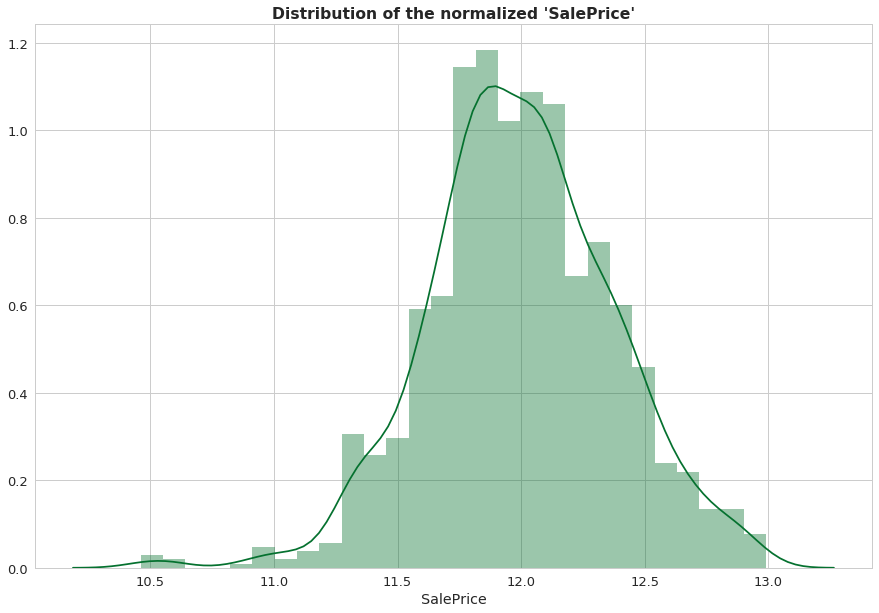

In [27]:
# NORMALIZE THE TARGET VARIABLE TO SIMPLIFY THE MODEL's WORK
trainPCA["SalePrice"] = np.log1p(trainPCA["SalePrice"])

# PLOT AGAIN THE VALUES DISTRIBUTION
plt.figure(figsize=(15,10))
sns.distplot(trainPCA["SalePrice"]);
plt.title("Distribution of the normalized 'SalePrice'", weight="semibold");

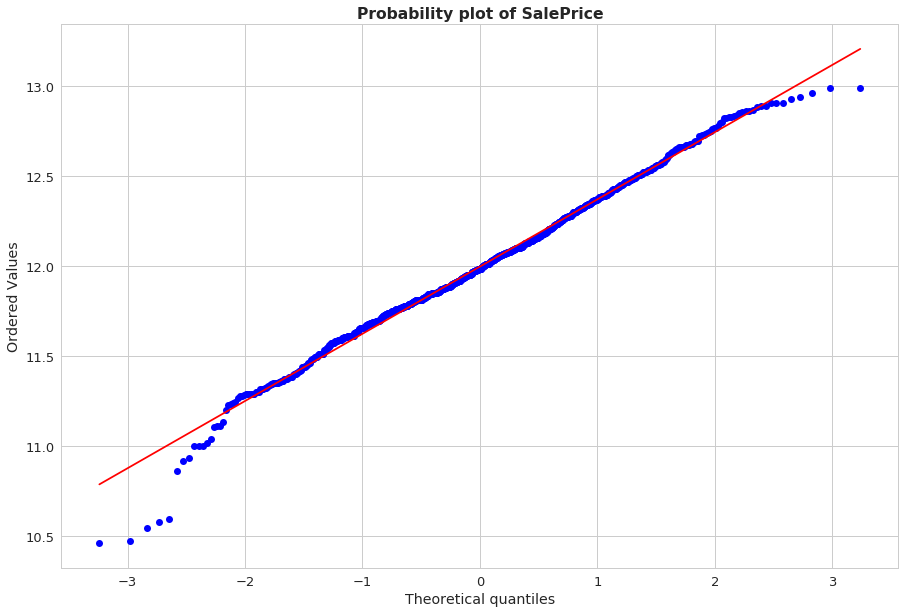

In [28]:
# PROBABILITY PLOT (SKEWNESS)
plt.figure(figsize=(15,10))
probplot(trainPCA['SalePrice'], plot=plt)
plt.title("Probability plot of SalePrice", weight="semibold")
plt.show()

<div class='alert alert-success'>
The log-transformation works perfectly, now we have a normal-distributed target variable. We do the same for all the other attributes and see the results.
</div>

### <span style='color:#606060'>2.5.2 Numerical attributes</span>

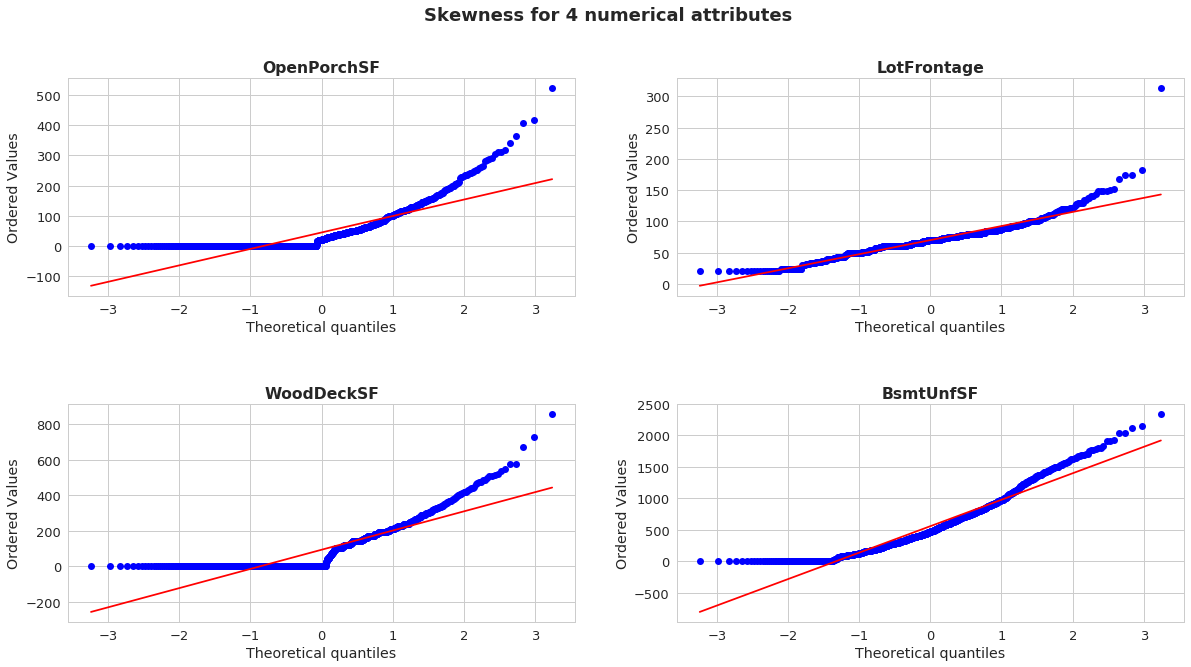

In [29]:
# PLOT THE ATTRIBUTES SKEWNESSES
plt.figure(figsize=(20,10))
for (i, attribute) in enumerate(['OpenPorchSF', 'LotFrontage', 'WoodDeckSF', 'BsmtUnfSF']):
    
    # PROBABILITY PLOT (SKEWNESS)
    plt.subplot(2, 2, i+1)
    probplot(trainPCA[attribute], plot=plt)
    plt.title(attribute, weight="semibold")

plt.suptitle("Skewness for 4 numerical attributes", weight="semibold", fontsize=18)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [30]:
for attribute in numericalAttributes:
    
    # NORMALIZE THE ATTRIBUTES VALUES TO SIMPLIFY THE MODEL's WORK
    trainPCA[attribute] = np.log1p(trainPCA[attribute])

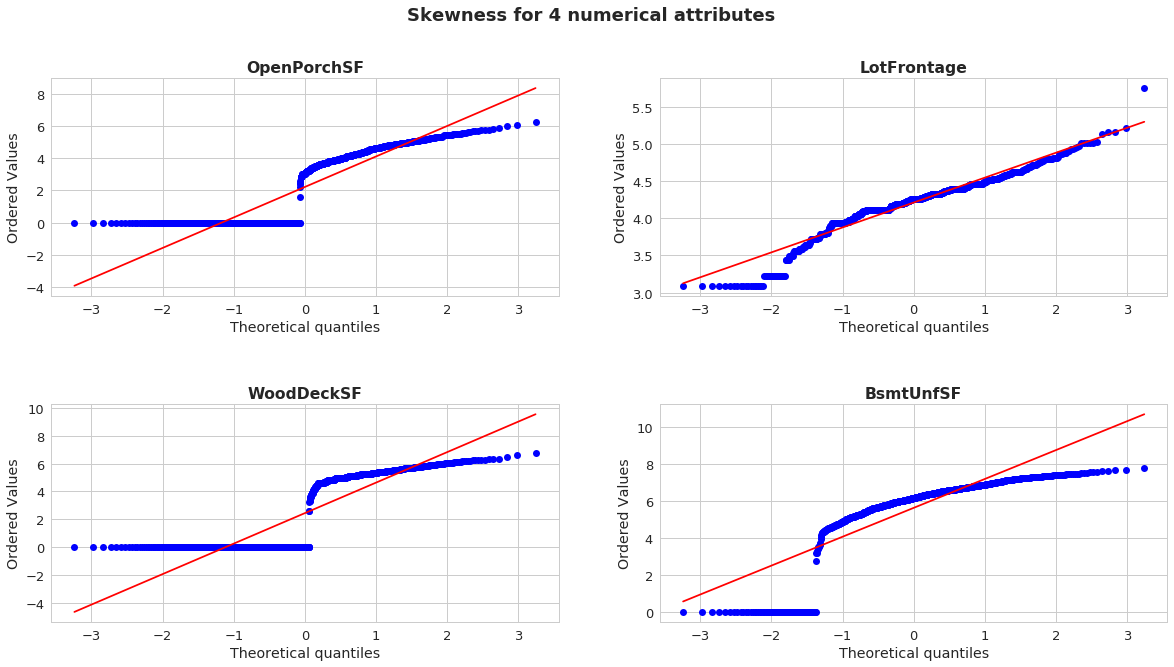

In [31]:
# PLOT THE ATTRIBUTES SKEWNESSES
plt.figure(figsize=(20,10))
for (i, attribute) in enumerate(['OpenPorchSF', 'LotFrontage', 'WoodDeckSF', 'BsmtUnfSF']):
    
    # PROBABILITY PLOT (SKEWNESS)
    plt.subplot(2, 2, i+1)
    probplot(trainPCA[attribute], plot=plt)
    plt.title(attribute, weight="semibold")

plt.suptitle("Skewness for 4 numerical attributes", weight="semibold", fontsize=18)
plt.subplots_adjust(hspace=0.5)
plt.show()

<div class='alert alert-success'>
This time the log-transformation isn't always so perfect but it is good anyway. The range of values have been squashed in a smaller range, for this reason we can notice "horizontal" lines in the plot: the points now differ one from each other for decimal values, so we can't appreciate these small differences in these plots.
</div>

### <span style='color:#606060'>2.5.3 Principal component analysis</span>

<div class='alert alert-info'>
<b>PCA</b> <i>(<b>P</b>rincipal <b>C</b>omponents <b>A</b>nalysis)</i> is the most known dimensionality reduction algorithm. Thanks to orthogonal transformations, tries to identify the most correlated dimensions (attributes) and reduce them to build a set of linearly independent dimensions called components (<a href="https://en.wikipedia.org/wiki/Principal_component_analysis">source</a>).
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/500px-GaussianScatterPCA.svg.png'>
<br>
Being our dataset really rich of attributes (79 at the beginning and over 200 after the encoding), removing outliers in the original dimensional space would have been unfeasible. We're going to use PCA to reduce the dimensionality of our dataset and identify the most evident outliers.<br>
<br>
Now we're going to use PCA to build the "Nth" principal components:
</div>

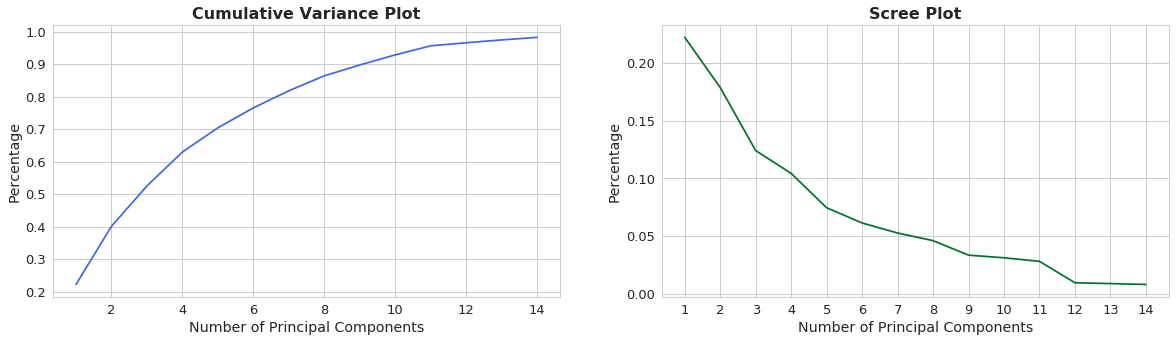

In [32]:
# COMPUTE PCA FOR A SET OF PRINCIPAL COMPONENTS NUMBER
sums = []
for i in range(1,15):
    pca = PCA(n_components=i, svd_solver='full')
    pc = pca.fit_transform(trainPCA[numericalAttributes])
    
    expl = np.sum(pca.explained_variance_ratio_)
    sums.append(expl)

# PLOT THE RESULT
plt.figure(figsize=(20,5))
ticks = np.arange(1, len(sums)+1)
plt.subplot(1,2,1)
plt.title("Cumulative Variance Plot", weight="semibold", fontsize=16)
plt.xlabel("Number of Principal Components")
plt.ylabel("Percentage")
plt.plot(ticks, sums, color="royalblue")
plt.subplot(1,2,2)
plt.title("Scree Plot", weight="semibold", fontsize=16)
plt.plot(ticks, pca.explained_variance_ratio_)
plt.xlabel("Number of Principal Components")
plt.ylabel("Percentage")
plt.xticks(ticks)
plt.show()

<div class='alert alert-success'>
It is always difficult to say how many components are sufficient to summarize the data. Looking at the scree plot, and using the elbow-method, we can say 9 but there is another elbow at 12. With 9 components we have more about 90% of the variance explained so we think it is enough. It is not really useful, but for the sake of completeness we plot the pairplot between these 9 components.
</div>

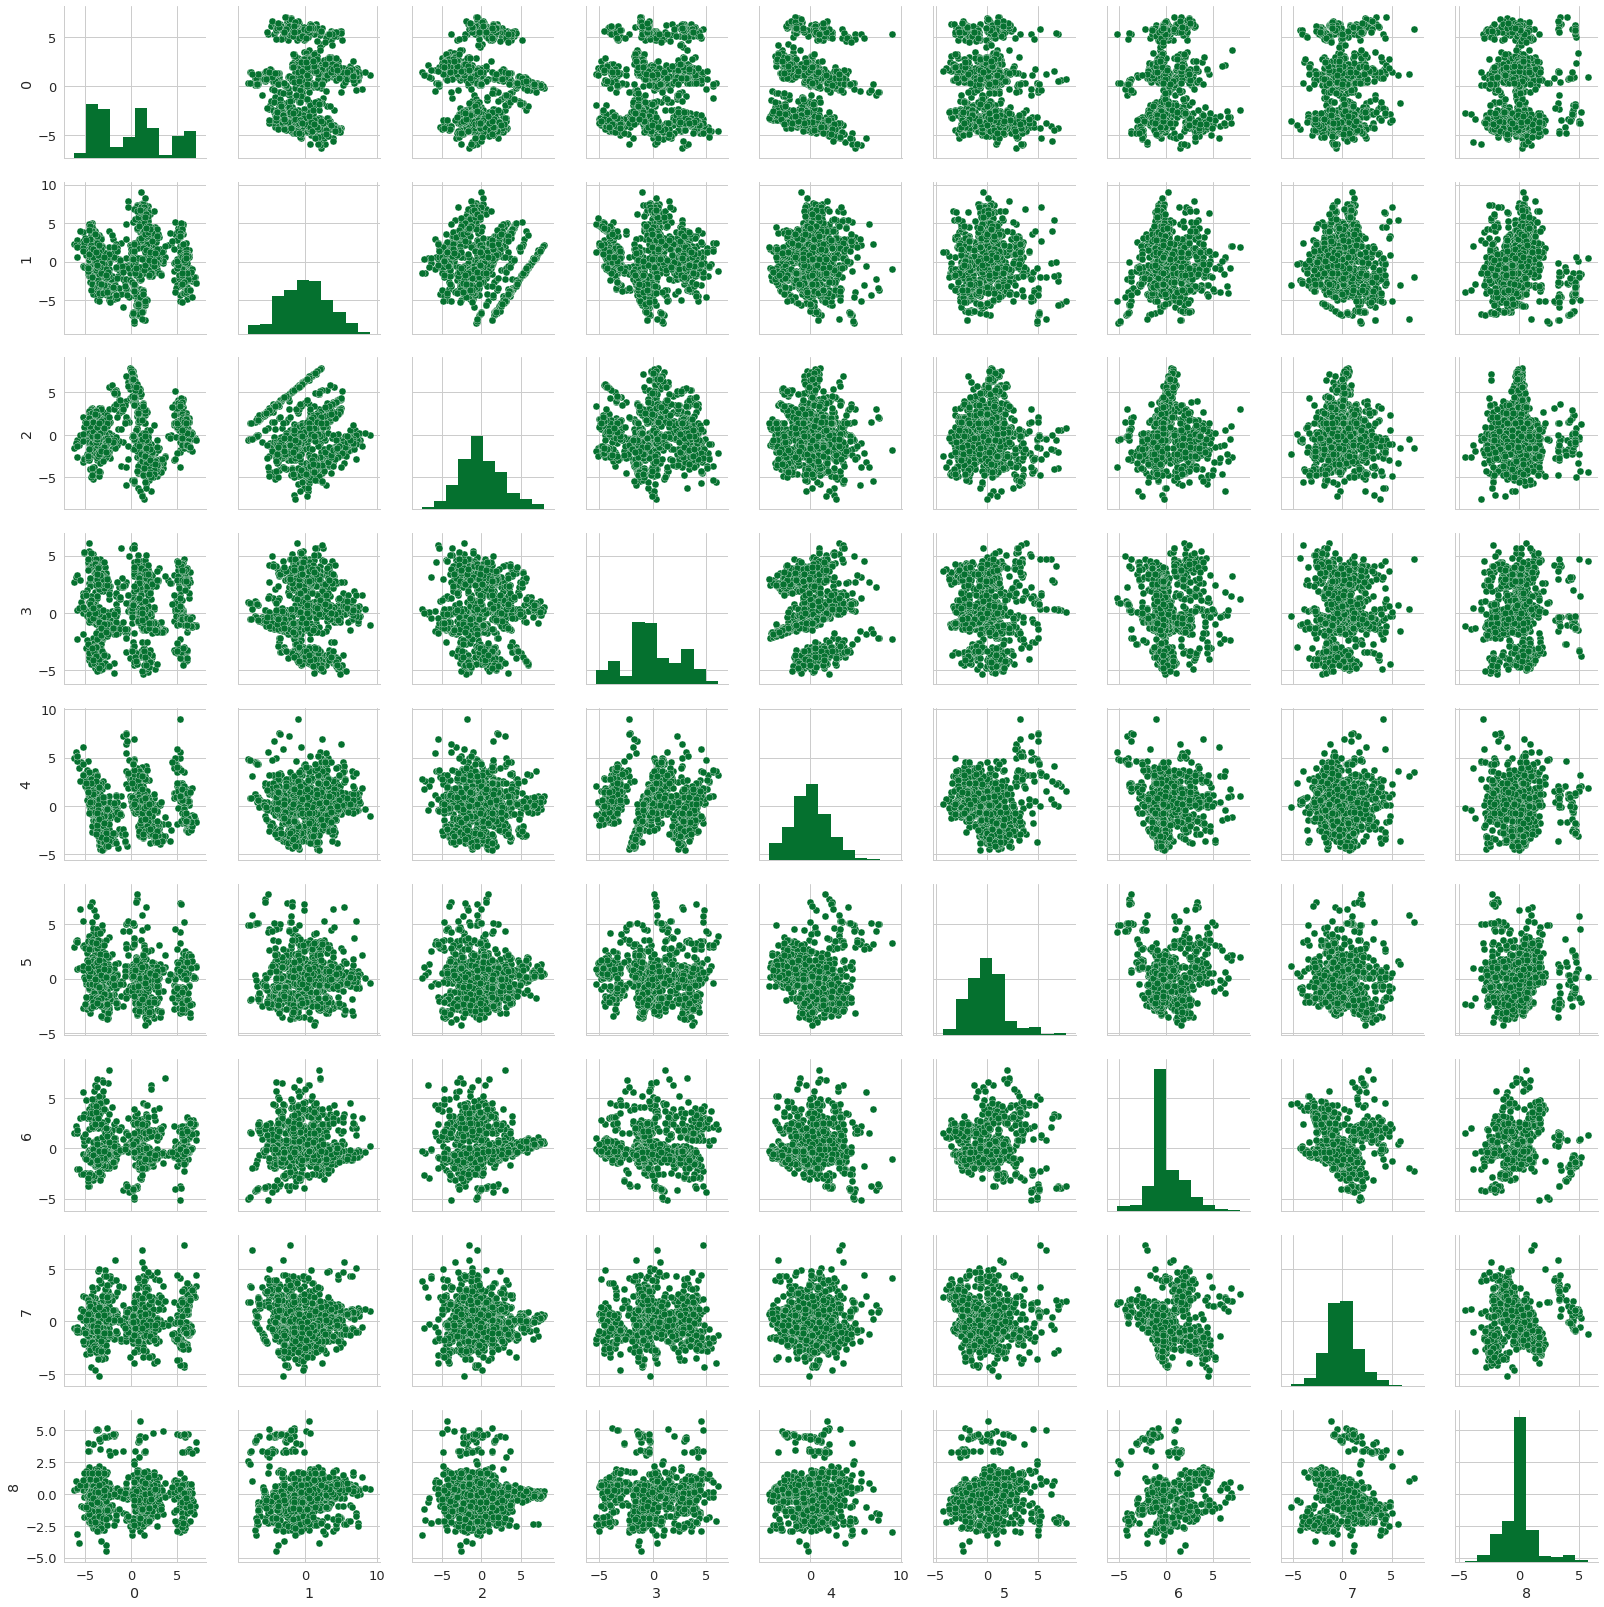

In [33]:
# CREATE A DATAFRAME WITH THE 9 PRINCIPAL COMPONENTS
pca = PCA(n_components=9, svd_solver='full')
pc = pca.fit_transform(trainPCA[numericalAttributes])
pdf = pd.DataFrame(data=pc)

# PLOT THE PRINCIPAL COMPONENTS PAIRPLOT
plt.figure(figsize=(10,10))
sns.pairplot(pdf)
plt.show()

### <span style='color:#606060'>2.5.4 DBSCAN</span>

<div class='alert alert-info'>
The DBSCAN algorithm <i>(<b>D</b>ensity-<b>B</b>ased <b>S</b>patial <b>C</b>lustering of <b>A</b>pplications with <b>N</b>oise)</i> is one of the most famous and used clustering algorithms, which can detect groups of points with similar attributes (clusters, indeed) using the density information between the points (<a href="https://en.wikipedia.org/wiki/DBSCAN">source</a>).<br>Its main parameters are the <i>eps</i> and the <i>min_samples</i>: the first one controls the maximum distance with which a point can be considered part of a cluster; the second one controls the minimum number of points of which a cluster can be composed.<br>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/500px-DBSCAN-Illustration.svg.png'>
<br>
Now we're going to use it to detect the outliers in the most important components generated after the PCA process:
</div>

<div class='alert alert-success'>
First of all we are going to consider only the two first components: the variance explained is about 40%; it is not too high but and we preferred to do a first cleaning phase only with them because it is handy to plot and show what we are doing/removing.<br><br>
There is no way to determine the proper values for the parameters of DBSCAN. With the helpness of the plot we tried many different parameters until we got a reasonable result.
</div>

Clusters, where '-1' is the outliers cluster:
{-1: 32,
 0: 329,
 1: 480,
 2: 181,
 3: 110,
 4: 27}

Index list of outliers:
[60, 80, 86, 178, 205, 217, 222, 229, 326, 334, 374, 390, 509, 518, 530, 580, 601, 612, 622, 640, 666, 680, 731, 737, 750, 892, 901, 970, 987, 991, 1085, 1101]


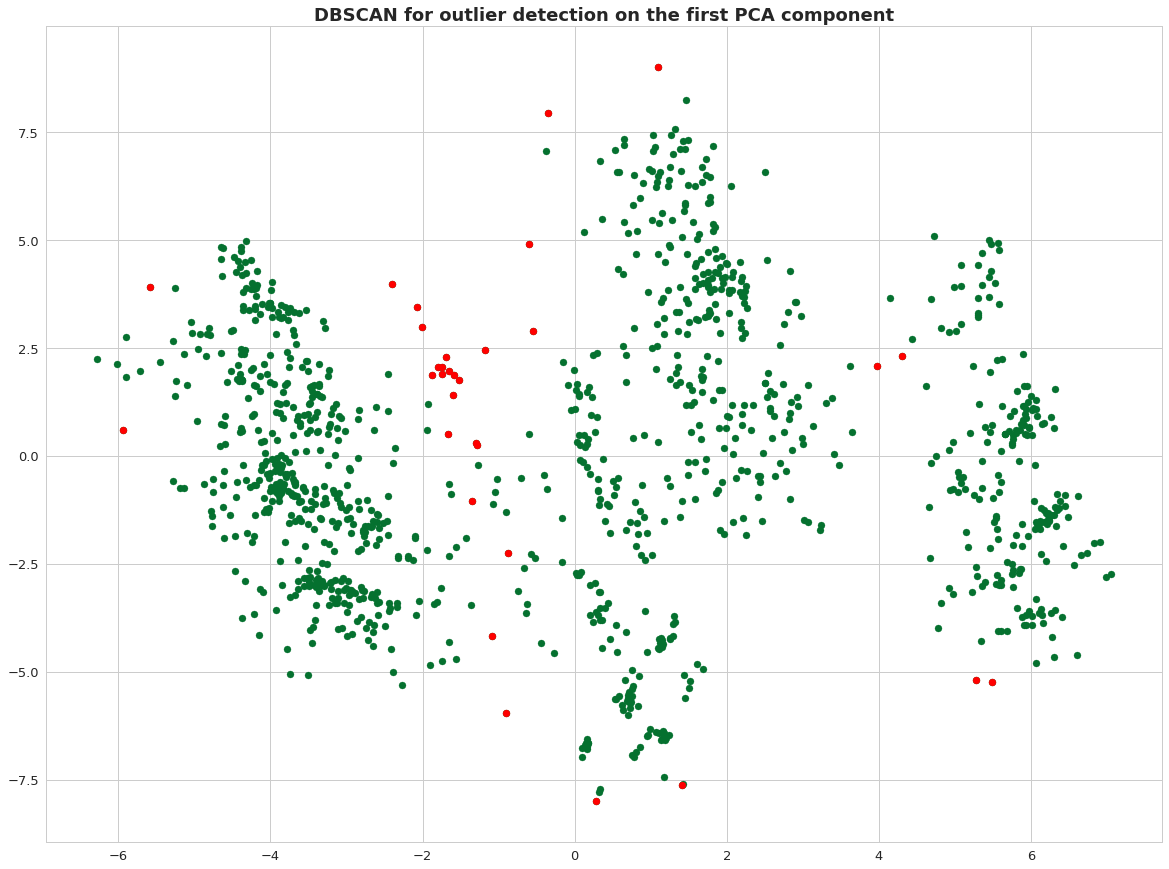

In [34]:
# CREATE A DATAFRAME WITH ONLY 2 PRINCIPAL COMPONENTS
pca = PCA(n_components=2, svd_solver='full')
pc = pca.fit_transform(trainPCA[numericalAttributes])
pdf = pd.DataFrame(data=pc)

# APPLY DBSCAN TO DETECT OUTLIERS
model = DBSCAN(eps=0.9, min_samples=15)
outliers = model.fit(pdf)

# SHOW THE CLUSTERS AND OUTLIERS COUNT
print("Clusters, where '-1' is the outliers cluster:")
clusters = Counter(outliers.labels_)
pprint(dict(clusters), width=1)

# SHOW THE ROW INDEXES OF THE OUTLIERS
onlyOutliers = pdf[outliers.labels_ == -1]
print("\nIndex list of outliers:")
print(list(onlyOutliers.index))

# PLOT THE PRINCIPAL COMPONENT SCATTERPLOT WITH THE OUTLIERS (IN RED)
plt.figure(figsize=(20,15))
plt.scatter(x=pdf[0], y=pdf[1])
plt.scatter(x=onlyOutliers[0], y=onlyOutliers[1], color="r")
plt.title("DBSCAN for outlier detection on the first PCA component", weight="semibold", fontsize=18)
plt.show()

<div class='alert alert-success'>
As we can see we removed a lot of isolated points that probably are outliers. In addition we removed really small cluster (less than 15 points) because we believe that in this case we consider them just as "a little cluster of noise". <br><br>
Now we are going to analyze data overall, taking all the 9 components. In this case we can't show anything and we can't have an idea about we are doing. It is a delicate operation because there is the risk to drop useful information. For this reason we set the parameters in order to remove only few points that are outside of the "big cluster" composed by (most) of the points (look at the first result). Maybe we could have applied a more aggressive approach but we can't have an idea about what we are removing: we chose a more conservative approach.
</div>

In [35]:
# APPLY 9-COMPONENTS PCA
pca = PCA(n_components=9, svd_solver='full')
pc = pca.fit_transform(trainPCA[numericalAttributes])
pdf = pd.DataFrame(data=pc)

# APPLY DBSCAN TO DETECT OUTLIERS
model = DBSCAN(eps=7.5, min_samples=25)
outliers = model.fit(pdf)

# SHOW THE CLUSTERS AND OUTLIERS COUNT
print("Clusters, where '-1' is the outliers cluster:")
clusters = Counter(outliers.labels_)
pprint(dict(clusters), width=1)

# SHOW THE ROW INDEXES OF THE OUTLIERS
onlyOutliers = pdf[outliers.labels_ == -1]
print("\nIndex list of outliers:")
print(list(onlyOutliers.index))

Clusters, where '-1' is the outliers cluster:
{-1: 5,
 0: 1154}

Index list of outliers:
[352, 506, 680, 724, 840]


In [36]:
# REMOVING OUTLIERS FOR HIGHLY CORRELATED ATTRIBUTES
# (ONLY FOR TRAIN-SET!)

# TEMPORARY SPLIT
oldLength = allData.shape[0]
train = allData[np.isnan(allData["SalePrice"]) == False]
test = allData[np.isnan(allData["SalePrice"]) != False].drop(columns=['SalePrice'])

# OUTLIER REMOVAL
train = train.drop(train.index[[  60,   80,   86,  178,  205,  217,  222,  229,  326,  334,  374,
             390,  509,  518,  580,  601,  612,  622,  640,  666,  680,  731,
             737,  750,  764,  892,  901,  970,  977,  987,  991, 1085, 1101,
            1150, 352, 506, 724, 840]])

# RE-JOIN
allData = pd.concat((train, test)).reset_index(drop=True)

print("Now the number of rows (which was " + str(oldLength) + ") is now " + str(allData.shape[0]))

Now the number of rows (which was 1419) is now 1381


## <span style='color:#333333'>2.6 Skewness and regression</span>

<div class='alert alert-info'>
In the previous sections we have discussed many times that skewness is a problem for regression (but not only, think about PCA). At the end of the day we realized it is not good trying to figure out a solution that it is good for all the models. As we have said before, each model works with its own assumptions. As expected, the models which suffer this fact are the simplest ones, like the <i>Lasso</i> and similar ones.<br>
Other models we are going to use (<i>tree-based</i>) go <b>really well with original values</b>. In this terms, at this point adjusting the skewness of the target variable is the only thing to do, in order to avoid (as discussed in the first part of the notebook, see section 1.1) expensive houses drive the models. In the case of the simplest models, we simple are going to use the ready-to-use preprocessing modules in sklearn library, putting the best for the specific case in the pipeline of the model.
</div>

In [37]:
# EFFECTIVELY ADJUST THE SKEW OF THE TARGET VARIABLE (ONLY FOR IT)
train["SalePrice"] = np.log1p(train["SalePrice"])

# 3. Modeling

<div class='alert alert-info'>
We have cleaned and fixed our data as much as possible: now we are ready to apply models. This part is quite easier than the previous ones, we should tune properly our model and if we have done a good job in the previous part we would have good results.<br>
<br>
But tuning parameters is not so easy as one may think, especially when dealing with complex models that require a lot of parameters. For this reason we have used some optimization algorithms, like <b>Bayesian Optimization</b>, when this work is too hard by proceeding by hand: we'll talk about it in a moment. For the validation and comparison between model we will use a <b>10-folds cross-validation</b>.
</div>

In [38]:
## LIBRARIES IMPORT

# <-- Bayesian Optimization -->
from bayes_opt import BayesianOptimization

# <-- Model evaluation -->
from sklearn.model_selection import cross_val_score, KFold, train_test_split

# <-- Model utilities -->
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

# <-- Neural Network -->
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

# <-- XGBoost -->
import xgboost

# <-- LightGBM -->
import lightgbm

# <-- Gradient Boosting -->
from sklearn.ensemble import GradientBoostingRegressor

# <-- Lasso | ElasticNet -->
from sklearn.linear_model import Lasso, ElasticNet

# <-- KernelRidge -->
from sklearn.kernel_ridge import KernelRidge

# <-- Stacking Regressor -->
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor


# TRAINSET SPLIT: FEATURES AND TARGET
features = train.drop(columns=["Id", "SalePrice"])
target = train["SalePrice"]

Using TensorFlow backend.


## 3.1 Neural Network

In [39]:
# FUNCTION TO BUILD THE NETWORK
def nnModel():
    
    # Create model
    model = Sequential()
    
    # Add the layers
    model.add(Dense(1000, input_dim=215, kernel_initializer='normal', activation="relu"))
    model.add(Dense(100, kernel_initializer='normal', activation="relu"))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


# BUILD MODEL
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=nnModel, epochs=50, batch_size=32, verbose=False)))
nn = make_pipeline(MinMaxScaler(), Pipeline(estimators))

# EVALUATE MODEL
nnCV = np.mean(np.sqrt(-cross_val_score(nn, features, target, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.3f" % nnCV)

# FIT MODEL
nn.fit(features, target);

CV (RMSE): 0.211


<div class='alert alert-success'>
The obtained result is awful (with respect to others, we will see). We tried different neural network structures, trying to adding/removing layers and neurons for each of the last ones but couldn't do better than the showed result. Maybe there is a problem of overfitting, for this reason we try to use different solutions to solve this (for example drop-out) but with no success. We should have more data in order to have a good neural network but it is not the case. For this reason we aren't going to consider this model anymore.
</div>

## 3.2 Tree-based models

<div class='alert alert-info'>
The first kind of algorithms we're going to use are tree-based models. These models will use decision-trees as base models but, of course, are not limited in their simlple application. The main idea, indeed, is to focus and find some patterns on the data in which the simple base models performs badly: in this way a lot of "satellite" models are created that can perform better in the data spaces in which we had a lot of error. A set of weights is then applied to combine the models generated and a differentiable loss function is exploited to concretely do the optimization.<br>
<br>
This ensemble technique is generally known as <b>boosting</b>. We will use in this notebbok three different techniques, known as <i>XGBoost (e<b>X</b>treme <b>G</b>radient <b>B</b>oosting)</i>, <i>LightGBM (<b>Light</b> <b>G</b>radient <b>B</b>oosting <b>M</b>achine)</i> and the general <i>Gradient Boosting.</i> Each mode uses different base models and optimization techniques, but they have a key feature in common, which is the gradient boosting.<br>
<br>
Boosting, in general, refers to decrease the bias (not the variance), so is suitable with low-variance, high-bias models. In the case of gradient boosting, the algorithm aims to find an approximation $\hat{F}(x)$ to a function $F(x)$ that minimizes the expected value of a loss function $L(y,F(x))$ (<a href="https://en.wikipedia.org/wiki/Gradient_boosting">source</a>):<br>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/655597bea9c34023b858924a1cf23b177042291c"><br>
Before seeing the models application, let's talk and introduce the technique that led us to find the best parameters for our models, Bayesian Optimization:
</div>

### 3.2.1 Bayesian optimization

<div class='alert alert-info'>
The <i>Bayesian Optimization</i> is a global optimization technique of functions, which exploits Gaussian Processes.<br>
<br>
The idea behind Gaussian Processes <i>(GPs)</i> is to treat the function as a random function, <b>building a posterior distribution</b> of functions that best describes the real function. This is done thanks to a chosen kernel which helps computing the covariance of prior and posterior; in this way the function is approximated, with more errors in the ranges in which there is a big lack of real sampled points (source <a href="https://en.wikipedia.org/wiki/Bayesian_optimization">here</a> and <a href="https://github.com/fmfn/BayesianOptimizationhere">here</a> for Bayesian Optimization, <a href="https://github.com/claudioscalzo/asi/blob/master/gaussian_processes.ipynb">here</a> for the ASI Gaussian Processes lab).
<img src="https://github.com/claudioscalzo/asi/blob/master/gp.png?raw=true">
<br>
Bayesian Optimization uses GPs over and over through the iterations, balancing two main aspects: <b>exploration and exploitation</b>. A Gaussian Process is fitted to the points previously explored (the known sampled points); the posterior distribution - in combination with a given exploration strategy (<i>Upper Confidence Bound</i>, <i>Expected Improvement</i>, etc.) - will choose the next point to explore.
</div>

### 3.2.2 XGBoost

<div class='alert alert-info'>
XGBoost is the first gradient boosting method we will use. It exploits as base models the CARTs (Classification And Regression Trees), splitting nodes in the trees according to some rules (like in decision trees) and adding a score to each leaf. The function can be written as:<br>
$$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$$<br>
where <tt>K</tt> is the number of trees, <tt>F</tt> is the tree space and <tt>f</tt> is a function in that space (<a href="http://xgboost.readthedocs.io/en/latest/model.html">source</a>).
</div>

<div class='label label-success'>BAYESIAN OPTIMIZATION</div>

In [42]:
# FUNCTION TO COMPUTE THE CROSS-VALIDATION FOR THE XGBOOST
def xgbComputeCV(depth, gamma, mcw, ss, cs, alpha, lam, lr):
    
    # INIT
    RMSEbest = 10.0
    ITERbest = 0
    folds = 10

    # PARAMETERS
    parameters = {
        'booster' : 'gbtree',
        'max_depth' : depth.astype(int),
        'gamma' : gamma,
        'objective': 'reg:linear',
        'nthread' : 2,
        'silent' : True,
        'eval_metric': 'rmse',
        'subsample' : ss,
        'colsample_bytree' : cs,
        'min_child_weight' : mcw,
        'learning_rate': lr,
        'reg_alpha': alpha,
        'reg_lambda': lam,
        'seed' : 0
    }
    
    # CROSS-VALIDATION
    xgbCV = xgboost.cv(
        parameters,
        dtrain,
        num_boost_round = 2000,
        nfold = folds,
        verbose_eval = False,
        early_stopping_rounds = 50,
        metrics = "rmse",
        show_stdv = True
    )

    # UPDATE CROSS-VALIDATIONS SCORE
    cvScore = xgbCV['test-rmse-mean'].iloc[-1]
    if (cvScore < RMSEbest):
        RMSEbest = cvScore
        ITERbest = len(xgbCV)

    return (-1.0 * cvScore)


# BUILD DENSE MATRIX
dtrain = xgboost.DMatrix(features, label=target)

# BAYESIAN OPTIMIZER FOR XGBOOST
bayesianOptimizerXGB = BayesianOptimization(xgbComputeCV, {'depth': (3, 5),
                                                           'gamma': (0.01, 0.10),
                                                           'mcw': (2, 5),
                                                           'ss': (0.4, 0.9),
                                                           'cs' :(0.1, 0.6),
                                                           'alpha': (0.1, 1),
                                                           'lam': (0.1, 1),
                                                           'lr': (0.01, 0.5)})

# MAXIMIZE
bayesianOptimizerXGB.maximize(init_points=10, n_iter=20, acq="ei")
    
# PRINT BEST PARAMETERS
print("\nMaximal parameters:")
pprint(bayesianOptimizerXGB.res['max']['max_params'], width=1)

Initialization
-----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |        cs |     depth |     gamma |       lam |        lr |       mcw |        ss | 
    1 | 00m03s |   -0.12884 |    0.6299 |    0.2843 |    4.8167 |    0.0343 |    0.2281 |    0.3439 |    2.2785 |    0.6203 | 
    2 | 00m07s |   -0.12254 |    0.8867 |    0.5288 |    3.3813 |    0.0414 |    0.6470 |    0.1274 |    2.2703 |    0.8713 | 
    3 | 00m04s |   -0.13367 |    0.9523 |    0.2117 |    4.7370 |    0.0411 |    0.2159 |    0.3340 |    2.5096 |    0.5115 | 
    4 | 00m02s |   -0.13792 |    0.8665 |    0.1386 |    3.9648 |    0.0937 |    0.3296 |    0.4036 |    2.1251 |    0.5699 | 
    5 | 00m03s |   -0.12131 |    0.1411 |    0.2997 |    4.6628 |    0.0134 |    0.9396 |    0.1998 |    3.3236 |    0.6973 | 
    6 | 00m05s |   -0.13847 |    0.7288 |    0.4185 |    4.7013 |    0.0527 |    0.5083 |    0.49

In [39]:
# BUILD XGB MODEL
xgb = xgboost.XGBRegressor(colsample_bytree=0.192,
                             gamma=0.012, 
                             max_depth=3,
                             learning_rate=0.010645,
                             min_child_weight=5, 
                             reg_alpha=0.22495,
                             reg_lambda=0.706,
                             subsample=0.548633,
                             n_estimators=2000,
                             nthread = 4,
                             seed=5)

# EVALUATE THE MODEL
xgbCV = np.mean(np.sqrt(-cross_val_score(xgb, features, target, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.5f" % xgbCV)

# FIT THE MODEL
xgb.fit(features, target);

CV (RMSE): 0.11264


<div class='alert alert-success'>
Thanks to Bayesian Optimization we got the parameters set in order to have a really good CV (0.114). XGBoost is a (really) smart model but we can't think that it is enough. We are going to test other models in order to have a general idea about which model performs better or worse and then aggregating them we can obtain really smart models.
</div>

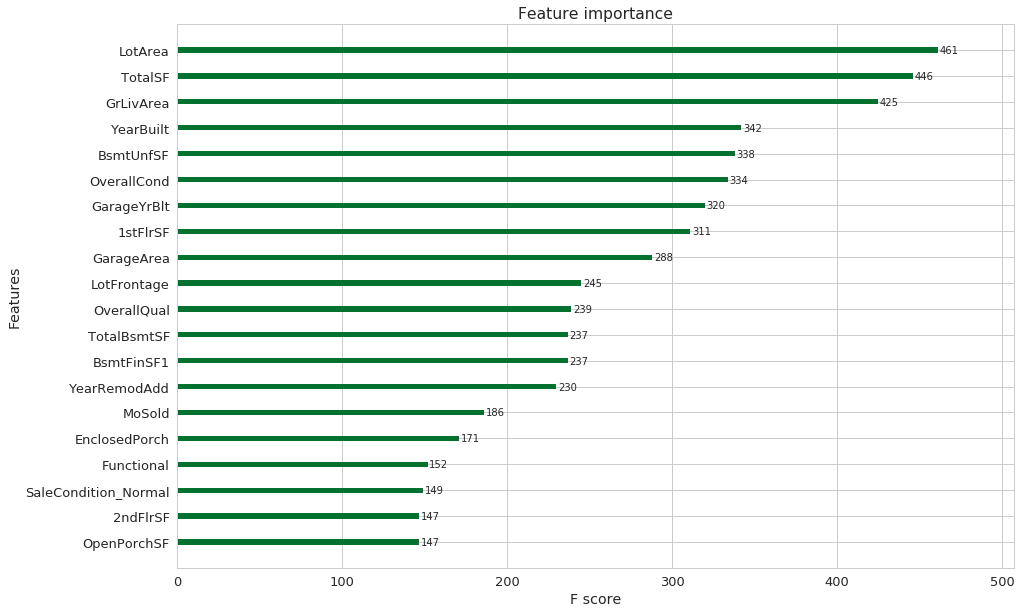

In [40]:
# PLOT THE XGBOOST's MOST IMPORTANT FEATURES
ax = xgboost.plot_importance(xgb, max_num_features=20)
fig = ax.figure
fig.set_size_inches(15, 10)

<div class='alert alert-success'>
As we can see from the "Feature Importance Plot" generated by the XGBoost model, the most important feature is <tt>TotalSF</tt>. This is the feature we added during the feature engineering phase! This means that the model has heavily followed this attribute during the prediction, being it correlated a lot with our target <tt>SalePrice</tt>.<br>
The other important features are, as we expected, the <tt>LotArea</tt>, the <tt>GrLivArea</tt>, the <tt>YearBuilt</tt> and the <tt>OverallCond</tt>: most of them were already present in the plots we computed examinating the most correlated attributes with the target, after we computed the correlation matrix.
</div>

### 3.2.3 LightGBM

<div class='alert alert-info'>
LigthGBM is another tree-based boosting model developed by Microsoft. It can't be used with any dataset, because is very sensible to overfitting, so it's dangerous to use it with small datasets: indeed, we'll be very careful with its results.<br>
<br>
Its main feature is to grow trees vertically instead of the classical "horizontal" fashion. The tree growing, indeed, is considered to be "leaf-wise" and not the classical "level-wise".
<img src="https://cdn-images-1.medium.com/max/1000/1*AZsSoXb8lc5N6mnhqX5JCg.png" width=500px>
<img src="https://cdn-images-1.medium.com/max/1000/1*whSa8rY4sgFQj1rEcWr8Ag.png" width=500px>
<br>
Also in this case we'll use Bayesian Optimization to try to find the best parameters:
</div>

<div class='label label-success'>BAYESIAN OPTIMIZATION</div>

In [60]:
# FUNCTION TO COMPUTE THE CROSS-VALIDATION FOR THE LGBOOST
def lgbComputeCV(lr, nlvs, max_bin, bg_frac, bg_freq, ft_frac, mdil, mshil):
    
    lgb = lightgbm.LGBMRegressor(objective='regression',
                                num_leaves=nlvs.astype(int),
                                learning_rate=lr,
                                max_bin = max_bin.astype(int),
                                bagging_fraction = bg_frac,
                                bagging_freq = bg_freq.astype(int),
                                feature_fraction = ft_frac,
                                min_data_in_leaf = mdil.astype(int),
                                min_sum_hessian_in_leaf = mshil,
                                n_estimators = 1000)
    
    kf = KFold(n_splits=10, shuffle=True)
    lgbCV = np.mean(np.sqrt(-cross_val_score(lgb, features, target, scoring="neg_mean_squared_error", cv = kf)))

    return (-1.0 * lgbCV)


# BAYESIAN OPTIMIZER FOR GBOOST
bayesianOptimizerLGB = BayesianOptimization(lgbComputeCV, {'lr': (0.01, 1),
                                                           'nlvs': (4, 6),
                                                           'max_bin': (30, 60),
                                                           'bg_frac': (0.5, 1),
                                                           'bg_freq': (3, 7),
                                                           'ft_frac' :(0.1, 0.5),
                                                           'mdil': (4, 8),
                                                           'mshil': (8, 14)})

# MAXIMIZE
bayesianOptimizerLGB.maximize(init_points=10, n_iter=25, acq="ei")
    
# PRINT BEST PARAMETERS
print("\nMaximal parameters:")
pprint(bayesianOptimizerLGB.res['max']['max_params'], width=1)

Initialization
-----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bg_frac |   bg_freq |   ft_frac |        lr |   max_bin |      mdil |     mshil |      nlvs | 
    1 | 00m26s |   -0.14441 |    0.5581 |    4.1288 |    0.3504 |    0.4417 |   57.6549 |    6.7934 |    9.3997 |    5.6067 | 
    2 | 00m23s |   -0.12970 |    0.9047 |    6.6660 |    0.2709 |    0.3785 |   59.8110 |    6.3325 |   10.7726 |    4.8473 | 
    3 | 00m28s |   -0.13828 |    0.9189 |    4.2424 |    0.1115 |    0.4829 |   30.7183 |    5.6437 |   13.0576 |    5.9063 | 
    4 | 00m26s |   -0.21236 |    0.6466 |    5.7606 |    0.3616 |    0.9962 |   52.3322 |    6.6731 |   12.6662 |    5.4136 | 
    5 | 00m22s |   -0.14579 |    0.9603 |    4.7706 |    0.3324 |    0.6240 |   31.6250 |    6.1862 |   11.5096 |    4.9012 | 
    6 | 00m28s |   -0.11413 |    0.7031 |    5.3293 |    0.1903 |    0.0468 |   32.0384 |    4.61

In [71]:
# BUILD MODEL
lgb = lightgbm.LGBMRegressor(objective='regression',
                            num_leaves=5,
                            learning_rate=0.018137262887703506,
                            max_bin = 33,
                            bagging_fraction = 0.675143585645422,
                            bagging_freq = 4,
                            feature_fraction = 0.41368880752443893,
                            min_data_in_leaf=4,
                            min_sum_hessian_in_leaf=13.03137443893148,
                            n_estimators=1000,
                            seed=5)

# EVALUATE THE MODEL
lgbCV = np.mean(np.sqrt(-cross_val_score(lgb, features, target.values, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.5f" % lgbCV)

# FIT THE MODEL
lgb.fit(features, target);

CV (RMSE): 0.11390


### 3.2.4 Gradient Boosting

<div class='alert alert-info'>
Here we're going to use the classic Gradient Boosting implementation, that we've explained in the previous cells. First of all, like before, let's find the parameters with Bayesian Optimization:
</div>

<div class='label label-success'>BAYESIAN OPTIMIZATION</div>

In [82]:
# FUNCTION TO COMPUTE THE CROSS-VALIDATION FOR THE GBOOST
def gbComputeCV(lr, max_d, msl, mss):
    
    gb =  GradientBoostingRegressor(learning_rate=lr,
                                max_depth=max_d.astype(int),
                                max_features='sqrt',
                                min_samples_leaf=msl.astype(int),
                                min_samples_split=mss.astype(int), 
                                loss='ls',
                                n_estimators=1000)
    
    kf = KFold(n_splits=10, shuffle=True)
    gbCV = np.mean(np.sqrt(-cross_val_score(gb, features, target, scoring="neg_mean_squared_error", cv = kf)))

    return (-1.0 * gbCV)


# BAYESIAN OPTIMIZER FOR GBOOST
bayesianOptimizerGB = BayesianOptimization(gbComputeCV, {'lr': (0.01, 1),  
                                                         'max_d': (2, 6),
                                                         'msl': (2, 6),
                                                         'mss': (6, 10)})

# MAXIMIZE
bayesianOptimizerGB.maximize(init_points=10, n_iter=25, acq="ei")
    
# PRINT BEST PARAMETERS
print("\nMaximal parameters:")
pprint(bayesianOptimizerGB.res['max']['max_params'], width=1)

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |        lr |     max_d |       msl |       mss | 
    1 | 00m03s |   -0.11479 |    0.0236 |    2.9824 |    4.5778 |    9.3240 | 
    2 | 00m07s |   -0.11546 |    0.0231 |    4.5347 |    2.2625 |    8.0222 | 
    3 | 00m03s |   -0.17086 |    0.8076 |    2.7857 |    5.8285 |    7.8631 | 
    4 | 00m05s |   -0.12497 |    0.2004 |    3.4251 |    2.2337 |    9.8908 | 
    5 | 00m09s |   -0.13720 |    0.3188 |    4.3890 |    4.9468 |    9.6652 | 
    6 | 00m05s |   -0.18379 |    0.8458 |    4.8627 |    3.7914 |    8.6798 | 
    7 | 00m03s |   -0.16049 |    0.7183 |    2.6835 |    2.8458 |    8.1033 | 
    8 | 00m05s |   -0.16879 |    0.7876 |    3.9837 |    5.8392 |    8.4876 | 
    9 | 00m05s |   -0.12540 |    0.2103 |    3.6198 |    5.4597 |    6.1489 | 
   10 | 00m05s |   -0.19893 |    0.9462 |    4.7887 |    5.0592 |    9.3649 | 
Bayesian Optimization
----------------

In [41]:
##### BUILD THE MODEL
gb =  GradientBoostingRegressor(learning_rate=0.013656,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=4,
                                min_samples_split=8, 
                                loss='ls',
                                n_estimators=1000,
                                random_state=5)

# EVALUATE THE MODEL
gbCV = np.mean(np.sqrt(-cross_val_score(gb, features, target, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.5f" % gbCV)

# FIT THE MODEL
gb.fit(features, target);

CV (RMSE): 0.11322


## 3.3 Regularized regressors

<div class='alert alert-info'>
From this moment we will try simpler linear regression models: Lasso, Ridge and ElasticNet. What are the characteristics of these models? In general when we train a model, we try to minimize the loss function (MSE and others) but, depending on the data, it is not good focusing only in this. That's because the final set of parameters could have high magnitude and the final model leads to have high variance (penalizing the performance). For this reason in the loss function we can add an addition factor, the regularization, in order to find a trade-off between MSE (or other metric) and goodness of parameters. The are two types of regularization: L1 and L2.<br>
- In L1 the parameter values are pulled towards zero proportionally to their absolute values<br>
- In L2 the parameter values are pulled towards zero proportionally to their squares
<img src="http://laid.delanover.com/wp-content/uploads/2018/01/reg_formulas.png" width=300px>
<br>
In order to have an idea of the "pull-to-zero power" of the two methods look at the graph below:
<img src="https://cdn-images-1.medium.com/max/2000/1*5daIfIud4cTtmpVnfSb5pQ.png" width=300px>
<br>
In general we can say that L2 pulls the parameters to zero more intensely than L1 but if we zoom in near zero we can find another story:
<img src="https://cdn-images-1.medium.com/max/2000/1*AgA43f_6wcNKZX4p-FmL8w.png" width=300px><br>
Near to zero we have the opposite behaviour: the L2 try not to pull so much towards zero, trying to find a better tradeoff. Of course there is no "the best": we should evaluate them case by case and that's what we are going to do.
</div>

### 3.3.1 Lasso

<div class='alert alert-info'>
In this section we will focus on Lasso. It exploits only L1 regularization.
</div>

In [48]:
# BUILD THE MODEL
lasso = make_pipeline(MinMaxScaler(), Lasso(alpha=0.00022))

# EVALUATE THE MODEL
lassoCV = np.mean(np.sqrt(-cross_val_score(lasso, features, target, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.5f" % lassoCV)

# FIT THE MODEL
lasso.fit(features, target);

CV (RMSE): 0.10978


### 3.3.2 KernelRidge

<div class='alert alert-info'>
In the case of Ridge we use L2 regularization. We will see if its usage is better.
</div>

In [49]:
# BUILD THE MODEL
kr = make_pipeline(RobustScaler(), KernelRidge(alpha=0.07, kernel='polynomial', degree=1))

# EVALUATE THE MODEL
krCV = np.mean(np.sqrt(-cross_val_score(kr, features, target, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.5f" % krCV)

# FIT THE MODEL
kr.fit(features, target);

CV (RMSE): 0.11307


### 3.3.3 ElasticNet

<div class='alert alert-info'>
Finally in ElasticNet we use a ratio between L1 and L2 regularization. It is another step to try to find a better compromise between the two approaches.
</div>

In [50]:
# BUILD THE MODEL
en = make_pipeline(MinMaxScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.6))

# EVALUATE THE MODEL
enCV = np.mean(np.sqrt(-cross_val_score(en, features, target, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.5f" % enCV)

# FIT THE MODEL
en.fit(features, target);

CV (RMSE): 0.11050


## 3.4 StackingRegressor1 (Lasso + ElasticNet + KernelRidge)

In [51]:
# BUILD THE META-REGRESSOR
svr = SVR(kernel='rbf', C=10)

# BUILD THE STACKED MODEL
stacked1 = StackingRegressor(regressors=[lasso, en, kr], meta_regressor=svr)

# EVALUATE THE MODEL
stacked1CV = np.mean(np.sqrt(-cross_val_score(stacked1, features, target, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.5f" % stacked1CV)

# FIT THE MODEL
stacked1.fit(features, target);

CV (RMSE): 0.10967


<div class='alert alert-success'>
As we expected, the CV of the stacked model is (slightly) better than the ones of each model alone. We've chosen the hyperparameter <tt>C</tt> of the Support Vector Regressor equal to 10 to maximize the CV score.
</div>

## 3.5 StackingRegressor2 (XGBoost + LightGBM + GradientBoosting)

In [79]:
# BUILD THE META-REGRESSOR
svr2 = SVR(kernel='rbf', C=1)

# BUILD THE STACKED MODEL
stacked2 = StackingRegressor(regressors=[xgb, lgb, gb], meta_regressor=svr2)

# EVALUATE THE MODEL
stacked2CV = np.mean(np.sqrt(-cross_val_score(stacked2, features, target, scoring="neg_mean_squared_error", cv = 10)))
print("CV (RMSE): %.5f" % stacked2CV)

# FIT THE MODEL
stacked2.fit(features, target);

#####################################################
from sklearn.metrics import mean_squared_error
test2 = pd.read_csv("./challenge_data/train2.csv")
target2 = test2.drop(test2.index[:1200])["SalePrice"]
stacked2Pred = stacked2.predict(test.drop(columns=["Id"]))
stacked2Error = np.sqrt(mean_squared_error(np.log1p(target2), stacked2Pred))
print("Stacked2 error:",  stacked2Error)

CV (RMSE): 0.11294
Stacked2 error: 0.1257916556184565


<div class='alert alert-success'>
Also in this case, the CV has improved with respect to the singular models!
</div>

# 3.6 Ensamble predictions

<div class='alert alert-info'>
At this point we have two stacking regressors: the first one composed by the simplest models and another one by tree-based ones. The cross-validation score are good enough for both but we can do a step further: we build another (simpler) model that is actually the weighted average between the two ones. In order to choose a proper set of model we can try different configurations and for each compute the cv-score, keeping the best set. We believe that in this way we can slightly improve again our results.<br><br>

For the sake of simplicity we didn't implement a "full-fledged" class model, implementing all the required methods to be compatible with the sklearn library. It isn't worth, it's just a weighted average. For this reason we implemented an easy and custom method to compute the CV of our "model". 
</div>

In [53]:
# CLASS FOR OUT CUSTOM MODEL
class AverageEnsemble:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        
    def fit(self, X, y):
        for m in self.models:
            m.fit(X, y)
            
    def predict(self, X):
        predictions = np.column_stack([
            m.predict(X) for m in self.models
        ])
        return np.average(predictions, axis=1, weights=self.weights)

In [58]:
# FUNCTION TO COMPUTE THE CV
def customCV():
    sum_rmse = 0
    kf = KFold(n_splits=10, shuffle=True)
    for i in range(1):
        for train_index, test_index in kf.split(features):
            ensemble.fit(features.iloc[train_index], target.iloc[train_index])
            p = ensemble.predict(features.iloc[test_index])
            sum_rmse += np.sqrt(mean_squared_error(target.iloc[test_index], p))
    return sum_rmse/50

In [69]:
# COMPUTE CV FOR EACH SET OF WEIGHTS
for w in [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]:
   ensemble = AverageEnsemble([stacked1, stacked2], [w, 1-w])
   print("Weights: %.1f %.1f" % (w, 1-w), " |  CV-10:", customCV())

Weights: 0.5 0.5 CV-10: 0.1067757827289631
Weights: 0.6 0.4 CV-10: 0.10697260628734913
Weights: 0.7 0.3 CV-10: 0.10666849923182323
Weights: 0.8 0.2 CV-10: 0.10828719131081298
Weights: 0.9 0.1 CV-10: 0.10930113997430219


In [80]:
# ENSEMBLE THE PREDICTIONS
ensemble = AverageEnsemble([stacked1, stacked2], [0.75, 0.25])
#print("CV:", customCV())
ensemble.fit(features, target)
p = ensemble.predict(test.drop(columns=["Id"]))
ensembleError = np.sqrt(mean_squared_error(np.log1p(target2), p))
print("Ensemble error:",  ensembleError)

Ensemble error: 0.10557890800431247


# 4. Submission

In [ ]:
# submission = np.expm1(model_xgb.predict(test.drop(columns='Id')))

# sub = pd.DataFrame()
# sub['Id'] = test['Id']
# sub['SalePrice'] = submission
# sub.to_csv('submission.csv', index=False)